<a href="https://colab.research.google.com/github/sasquare/Olist_Ecomerce_Project_Analysis/blob/main/Olist_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install opendatasets

In [4]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
import opendatasets as od
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
#from viz_utils import *
#from custom_transformers import *
#from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [5]:
pip install opendatasets --upgrade --quiet

In [6]:
path1 = '/content/drive/MyDrive/olist/customers.csv'
path2 ='/content/drive/MyDrive/olist/geolocation.csv'
path3 ='/content/drive/MyDrive/olist/order_items.csv'
path4 ='/content/drive/MyDrive/olist/order_payments.csv'
path5 ='/content/drive/MyDrive/olist/order_reviews.csv'
path6 ='/content/drive/MyDrive/olist/orders.csv'
path7 ='/content/drive/MyDrive/olist/product_category.csv'
path8 = '/content/drive/MyDrive/olist/products.csv'
path9 = '/content/drive/MyDrive/olist/sellers.csv'


In [7]:
customers=pd.read_csv(path1)
geo_data=pd.read_csv(path2)
order_item =pd.read_csv(path3)
order_payment=pd.read_csv(path4)
oder_review=pd.read_csv(path5)
order=pd.read_csv(path6)
category=pd.read_csv(path7)
product=pd.read_csv(path8)
seller=pd.read_csv(path9)

In [8]:
#checking number of columns , column_names and no_of_rows

datasets = [customers,geo_data,order_item, order_payment, oder_review, order,category,product, seller]
titles = ["customers","geolocations","items", "payments", "reviews", "orders","category","products","sellers"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets]
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

### Observation(s):

* Dataset with maximum number of columns is products.
* Dataset with maximum number of rows is geolocations

In [9]:
#checking dtypes
datasets = [customers,geo_data,order_item, order_payment, oder_review, order,category,product, seller]
titles = ["customers","geolocations","items", "payments", "reviews", "orders","category","products","sellers"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Greys')

### Observation(s):

* products dataset has maximum number of numerical features(i.e dtype :'int16', 'int32', 'int64', 'float16', 'float32', 'float64').
* orders dataset has maximum number of features of object dtype
* We can also observe that all the timestamps are in object datatypes.So, we have to convert it into datetime type to do  analysis on these features.

In [10]:
#checking no of null values
#code source-https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

datasets = [customers,geo_data,order_item, order_payment, oder_review, order,category,product, seller]
titles = ["customers","geolocations","items", "payments", "reviews", "orders","category","products","sellers"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

### Observation(s):

* The maximum number of null-values are present in reviews dataset and the name of the columns with the null-values are review_comment_title and review_comment_message.
* products dataset contains least number of null- values but most of its columns has null-values.
* we have to deal with these null-values in future.

3.1.3. Merging all *datasets*

In [11]:
rev_new = oder_review.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

In [12]:
df = pd.merge(order,order_payment, on="order_id")
df = df.merge(customers, on="customer_id")
df = df.merge(order_item, on="order_id")
df = df.merge(product, on="product_id")
df = df.merge(category, on="product_category_name")
df = df.merge(rev_new, on="order_id")
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2017-08-17 15:28:33           2017-08-18 14:44:43   
4          2017-08-04 17:35:43           2017-08-07 18:30:01   

  order_estimated_delivery_date  payment_sequential payment_type  \
0           2017-10-18 00:00:00                   1  credit_card   
1           2017-10-18 00:00:00                   3      voucher   
2           2017-10-18 00:00:00                   2      voucher   
3           2017-08-28 00:00:00                   1  credit_card   
4           2017-08-15 00:00:00                   1  credit_card   

   payment_installments  payment_value                customer_unique_id  \
0                     1          18.12  7c396fd4830fd04220f754e42b4e5bff   
1                     1           2.00  7c396fd4830fd04220f754e42b4e5bff   
2                     1          18.59  7c396fd4830fd04220f754e42b4e5bff   
3                     3          37.77  3a51803cc0d012c3b5dc8b7528cb05f7   
4                     1          37.77  ef0996a1a279c26e7ecbd737be23d235   

   customer_zip_code_prefix customer_city customer_state  order_item_id  \
0                      3149     sao paulo             SP              1   
1                      3149     sao paulo             SP              1   
2                      3149     sao paulo             SP              1   
3                      3366     sao paulo             SP              1   
4                      2290     sao paulo             SP              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
4  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   

   shipping_limit_date  price  freight_value  product_category_name  \
0  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
1  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
2  2017-10-06 11:07:15  29.99           8.72  utilidades_domesticas   
3  2017-08-21 20:05:16  29.99           7.78  utilidades_domesticas   
4  2017-08-08 18:37:31  29.99           7.78  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       268.0                 4.0   
1                 40.0                       268.0                 4.0   
2                 40.0                       268.0                 4.0   
3                 40.0                       268.0                 4.0   
4                 40.0                       268.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
1             500.0             

In [13]:
print("Number of rows after merging:",len(df))
print("Number of columns after merging:",len(df.columns))

Number of rows after merging: 116581
Number of columns after merging: 33


3.1.3. Handling missing values

In [14]:
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date      1213
order_delivered_customer_date     2515
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty       

Handling Missing values in Timestamps

* The order of different types of timestamps are shown below:


    order_purchase_timestamp-->order_approved_at--> order_delivered_carrier_date-->order_delivered_customer_date-->order_estimated_delivery_dat
    e     

* Timestamps containg missing values are order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.

* null-values in order_approved_at can be replaced by order_purchase_timestamp and null-values in order_delivered_customer_date can be replaced by order_estimated_delivery_date
* we can drop the column order_delivered_carrier_date.

In [15]:
#Handling missing values
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [16]:
#checking the replaced values
df.order_estimated_delivery_date[index[0]]

'2017-07-06 00:00:00'

In [17]:
df.order_delivered_customer_date[index[0]]

'2017-07-06 00:00:00'

In [18]:
# Handling missing values of numerical features
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [19]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('no_review',inplace=True)

Percentage of null reviews : 57.21601290090151 %


#### 3.1.4 Data Dedublicate

In [20]:
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows.head()

order_id                       customer_id  \
1   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2   e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
8   82bce245b1c9148f8d19a55b9ff70644  388025bec8128ff20ec1a316ed4dcf02   
9   82bce245b1c9148f8d19a55b9ff70644  388025bec8128ff20ec1a316ed4dcf02   
10  82bce245b1c9148f8d19a55b9ff70644  388025bec8128ff20ec1a316ed4dcf02   

   order_status order_purchase_timestamp    order_approved_at  \
1     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2     delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
8     delivered      2017-04-20 17:15:46  2017-04-21 05:15:56   
9     delivered      2017-04-20 17:15:46  2017-04-21 05:15:56   
10    delivered      2017-04-20 17:15:46  2017-04-21 05:15:56   

   order_delivered_customer_date order_estimated_delivery_date  \
1            2017-10-10 21:25:13           2017-10-18 00:00:00   
2            2017-10-10 21:25:13           2017-10-18 00:00:00   
8            2017-05-10 09:17:55           2017-05-12 00:00:00   
9            2017-05-10 09:17:55           2017-05-12 00:00:00   
10           2017-05-10 09:17:55           2017-05-12 00:00:00   

    payment_sequential payment_type  payment_installments  payment_value  \
1                    3      voucher                     1           2.00   
2                    2      voucher                     1          18.59   
8                    1       boleto                     1         267.80   
9                    1       boleto                     1         267.80   
10                   1       boleto                     1         267.80   

                  customer_unique_id  customer_zip_code_prefix customer_city  \
1   7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
2   7c396fd4830fd04220f754e42b4e5bff                      3149     sao paulo   
8   f9effeed3df9ae063a58c0759b96f8b2                     85804      cascavel   
9   f9effeed3df9ae063a58c0759b96f8b2                     85804      cascavel   
10  f9effeed3df9ae063a58c0759b96f8b2                     85804      cascavel   

   customer_state  order_item_id                        product_id  \
1              SP              1  87285b34884572647811a353c7ac498a   
2              SP              1  87285b34884572647811a353c7ac498a   
8              PR              2  a5a0e71a81ae65aa335e71c06261e260   
9              PR              3  a5a0e71a81ae65aa335e71c06261e260   
10             PR              4  a5a0e71a81ae65aa335e71c06261e260   

                           seller_id  shipping_limit_date  price  \
1   3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
2   3504c0cb71d7fa48d967e0e4c94d59d9  2017-10-06 11:07:15  29.99   
8   c8417879a15366a17c30af34c798c332  2017-04-27 05:15:56  38.00   
9   c8417879a15366a17c30af34c798c332  2017-04-27 05:15:56  38.00   
10  c8417879a15366a17c30af34c798c332  2017-04-27 05:15:56  38.00   

    freight_value  product_category_name  product_name_lenght  \
1            8.72  utilidades_domesticas                 40.0   
2            8.72  utilidades_domesticas                 40.0   
8           15.56  utilidades_domesticas                 57.0   
9           15.56  utilidades_domesticas                 57.0   
10          15.56  utilidades_domesticas                 57.0   

    product_description_lenght  product_photos_qty  product_weight_g  \
1                        268.0                 4.0             500.0   
2                        268.0                 4.0             500.0   
8                        698.0                 3.0             705.0   
9                        698.0                 3.0             705.0   
10                       698.0                 3.0             705.0   

    product_length_cm  product_height_cm  product_width_cm  \
1                19.0                8.0              13.0   
2                19.0                8.0              13.0   
8                

In [21]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, keep='first', inplace=False)
df=df.reindex()
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
5  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
6  6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31  2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47  2017-08-02 18:43:15   
5    delivered      2017-10-23 23:26:46  2017-10-25 02:14:11   
6    delivered      2017-11-24 21:27:48  2017-11-25 00:21:09   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13           2017-10-18 00:00:00   
3           2017-08-18 14:44:43           2017-08-28 00:00:00   
4           2017-08-07 18:30:01           2017-08-15 00:00:00   
5           2017-11-07 18:04:59           2017-11-13 00:00:00   
6           2017-12-28 18:59:23           2017-12-21 00:00:00   

   payment_sequential payment_type  payment_installments  payment_value  \
0                   1  credit_card                     1          18.12   
3                   1  credit_card                     3          37.77   
4                   1  credit_card                     1          37.77   
5                   1       boleto                     1          44.09   
6                   1  credit_card                    10         356.12   

                 customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366   
4  ef0996a1a279c26e7ecbd737be23d235                      2290   
5  e781fdcc107d13d865fc7698711cc572                     88032   
6  3e4fd73f1e86b135b9b121d6abbe9597                     19400   

          customer_city customer_state  order_item_id  \
0             sao paulo             SP              1   
3             sao paulo             SP              1   
4             sao paulo             SP              1   
5         florianopolis             SC              1   
6  presidente venceslau             SP              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
4  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
5  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
6  be021417a6acb56b9b50d3fd2714baa8  f5f46307a4d15880ca14fab4ad9dfc9b   

   shipping_limit_date   price  freight_value  product_category_name  \
0  2017-10-06 11:07:15   29.99           8.72  utilidades_domesticas   
3  2017-08-21 20:05:16   29.99           7.78  utilidades_domesticas   
4  2017-08-08 18:37:31   29.99           7.78  utilidades_domesticas   
5  2017-10-31 02:14:11   29.99          14.10  utilidades_domesticas   
6  2017-11-30 00:21:09  339.00          17.12  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       268.0                 4.0   
3                 40.0                       268.0                 4.0   
4                 40.0                       268.0                 4.0   
5                 40.0                       268.0                 4.0   
6                 48.0                       664.0                 6.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
3             500.0               19.0                8.0              13.0   
4             500.0               19.0                8.0              13

In [22]:
print("Number of rows after dedublication:",len(df))
print("Number of columns after deduplication:",len(df.columns))

Number of rows after dedublication: 97255
Number of columns after deduplication: 32


## 3.2 Data Analysis







## 3.2.1.Statistics

In [23]:
# all time stamps are in object dtype as observed above converting it into dataetime
df[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date','order_estimated_delivery_date',]]=df[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97255 entries, 0 to 116580
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       97255 non-null  object        
 1   customer_id                    97255 non-null  object        
 2   order_status                   97255 non-null  object        
 3   order_purchase_timestamp       97255 non-null  datetime64[ns]
 4   order_approved_at              97255 non-null  datetime64[ns]
 5   order_delivered_customer_date  97255 non-null  datetime64[ns]
 6   order_estimated_delivery_date  97255 non-null  datetime64[ns]
 7   payment_sequential             97255 non-null  int64         
 8   payment_type                   97255 non-null  object        
 9   payment_installments           97255 non-null  int64         
 10  payment_value                  97255 non-null  float64       
 11  customer_uniqu

Observation(s):
* the final merged dataset has no null values.
* total number of columns is 32.
        dtype           |   number of columns
        ----------------|-------------------
        datetime64[ns]  |      4
                        |
        float64(10)     |      10
                        |
        int64           |      5
                        |
        object          |      13   

In [25]:
df.describe()

payment_sequential  payment_installments  payment_value  \
count        97255.000000          97255.000000   97255.000000   
mean             1.022590              2.922143     158.146126   
std              0.247582              2.714211     217.969505   
min              1.000000              0.000000       0.010000   
25%              1.000000              1.000000      60.100000   
50%              1.000000              2.000000     103.260000   
75%              1.000000              4.000000     175.640000   
max             27.000000             24.000000   13664.080000   

       customer_zip_code_prefix  order_item_id         price  freight_value  \
count              97255.000000   97255.000000  97255.000000   97255.000000   
mean               35146.411999       1.016400    125.965675      20.224175   
std                29787.788224       0.146554    190.885376      15.937371   
min                 1003.000000       1.000000      0.850000       0.000000   
25%                11380.000000       1.000000     41.900000      13.310000   
50%                24425.000000       1.000000     79.000000      16.390000   
75%                58862.500000       1.000000    139.900000      21.270000   
max                99980.000000       7.000000   6735.000000     409.680000   

       product_name_lenght  product_description_lenght  product_photos_qty  \
count         97255.000000                97255.000000        97255.000000   
mean             48.844697                  794.172197            2.250805   
std               9.996589                  654.971255            1.745965   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  349.000000            1.000000   
50%              52.000000                  607.000000            2.000000   
75%              57.000000                  996.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

       product_weight_g  product_length_cm  product_height_cm  \
count      97255.000000       97255.000000       97255.000000   
mean        2108.773235          30.160907          16.515644   
std         3767.241726          16.164995          13.342930   
min            0.000000           7.000000           2.000000   
25%          300.000000          18.000000           8.000000   
50%          700.000000          25.000000          13.000000   
75%         1813.000000          38.000000          20.000000   
max        40425.000000         105.000000         105.000000   

       product_width_cm  review_score  
count      97255.000000  97255.000000  
mean          23.068572      4.092078  
std           11.749203      1.341561  
min            6.000000      1.000000  
25%           15.000000      4.000000  
50%           20.000000      5.000000  
75%           30.000000      5.000000  
max          118.000000      5.000000

Observation(s):

* We can observe from the above table except customer_zip_code_prefix, order_item_id and review_score features we have 12 numerical features in our final dataset.

* Also,We can observe the statistics like percentile values , mean and standard deviation values, count , min and max of the numerical featues.For payment_value, the maximum payment value of an order is 13664 Brazilian real.

* For the price and freight value of an order. The maximum price of an order is 6735 while max freight is  around 410 Brazilian real. The average price of an order is around 125 Brazilian real and frieght value is around 20 Brazilian real. The order with minimum price of 0.85 Brazilian real have been made.

* Similarly, we can observe the other features further we will see the  distribution of these features and see how they are  helping  in classifying the class labels and find other insights.

In [26]:
# checking the target variables i.e review score
df.review_score.value_counts()

5    56274
4    18785
1    11011
3     8084
2     3101
Name: review_score, dtype: int64

In [27]:
def partition(x):
    if x < 3:
        return 0
    return 1
df['review_score']=df['review_score'].map(lambda cw : partition(cw) )

# checking the review score now
df.review_score.value_counts()

1    83143
0    14112
Name: review_score, dtype: int64

Total Positive Reviews : 83143 , ( 85.48969204668141 %)
Total Negative Reviews : 14112 , ( 14.510307953318597 %)




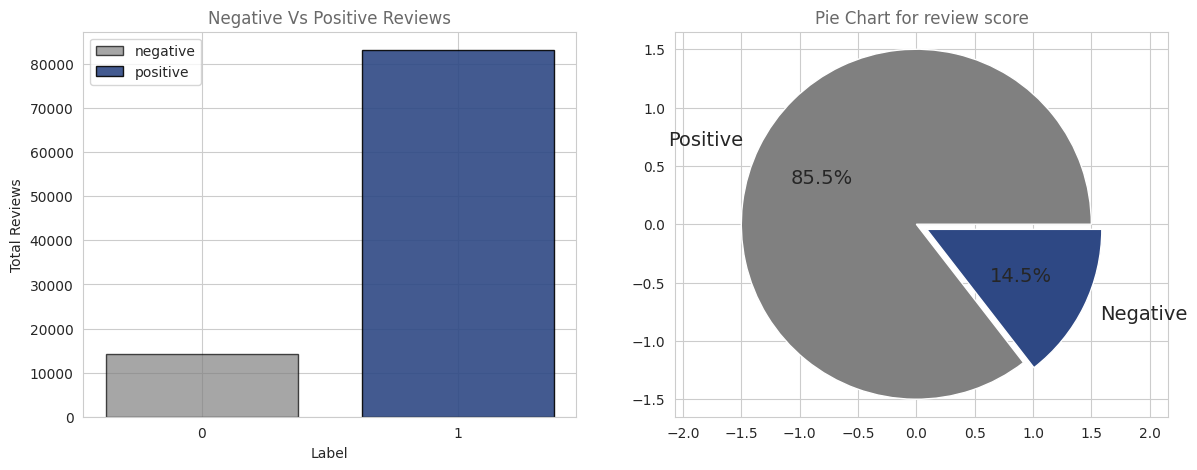

In [28]:
#counting the review score with 1 and 0
y_value_counts = df.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'grey', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = '#2e4884', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'#2e4884','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()


Observation(s):

* We can observe from the above plots 85.5% of the total reviews are positive i.e. 1 and only 14.5% reviews are negative i.e. which means that the given data set is imbalanced dataset.

In [29]:
#Correlation matrix
corr_matrix = df.corr()

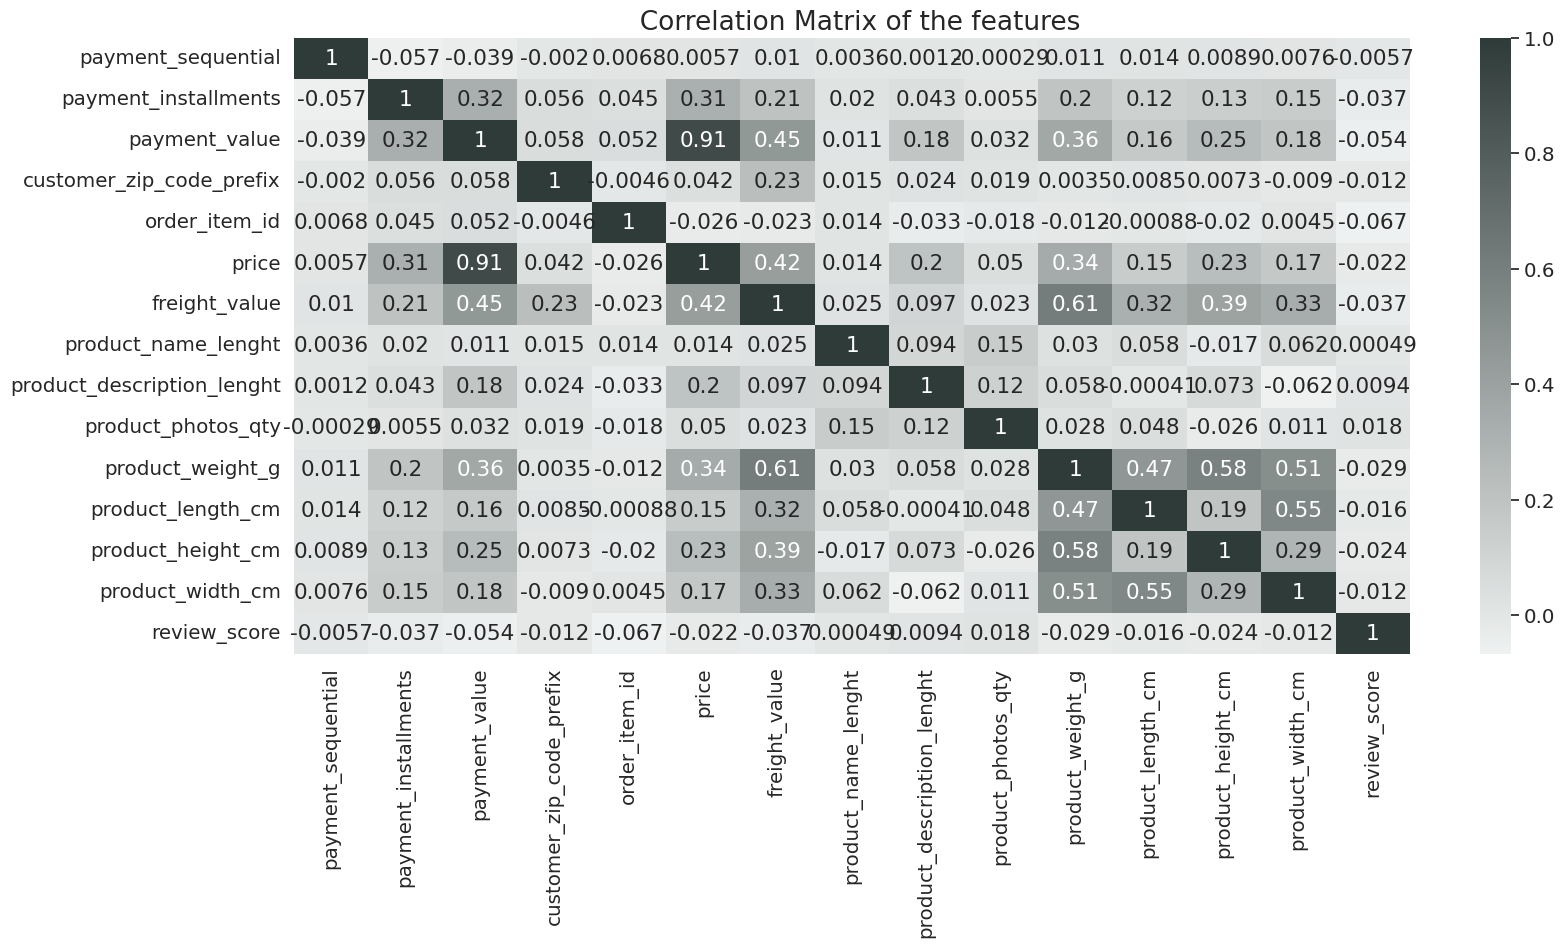

In [30]:
plt.figure(figsize=(18,8))
sns.set(font_scale=1.3)
cmap = sns.light_palette("#2f3b39",as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap,annot=True)
plt.title("  Correlation Matrix of the features",fontsize=19)
plt.savefig('plot16.png', dpi=300, bbox_inches='tight')
plt.show()

Observation(s):

* There is a strong positive correlation between: (payment_value and price), (product_weight_g and freight_value also with product_width_cm), (product_length_cm and product_width_cm), (product_height_cm and product_weight_g).

In [31]:
#finding corr- values of the features with review_score
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.018332
product_description_lenght    0.009377
product_name_lenght           0.000495
payment_sequential           -0.005685
customer_zip_code_prefix     -0.011552
product_width_cm             -0.011759
product_length_cm            -0.015763
price                        -0.022488
product_height_cm            -0.023692
product_weight_g             -0.028834
freight_value                -0.036928
payment_installments         -0.037245
payment_value                -0.054138
order_item_id                -0.066646
Name: review_score, dtype: float64

In [32]:
#checking unique ids
print("Total number of unique seller_id:",len((df.seller_id).unique()))
print("Total number of unique product_id:",len((df.product_id).unique()))
print("Total number of unique customer_id:",len((df.customer_unique_id).unique()))

Total number of unique seller_id: 3022
Total number of unique product_id: 31053
Total number of unique customer_id: 94087


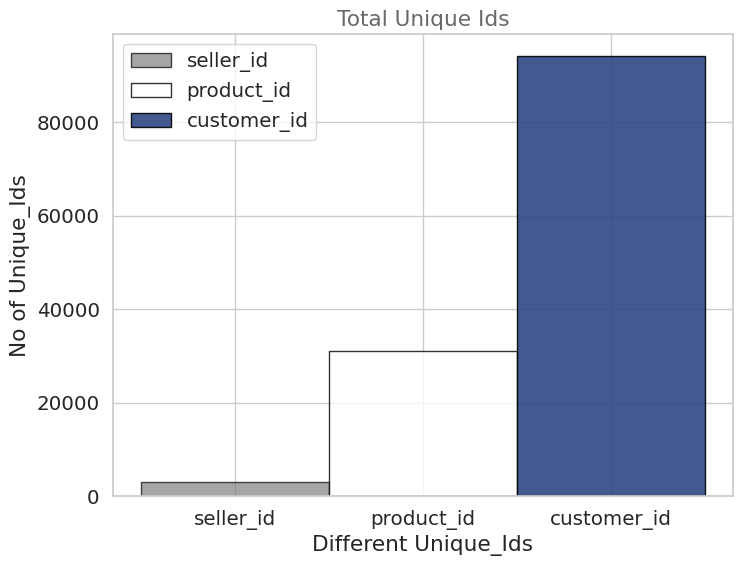

In [33]:
%matplotlib inline
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
plt.ylabel('No of Unique_Ids')
plt.xlabel('Different Unique_Ids')
plt.title('Total Unique Ids',color='dimgrey')
plt.xticks([10,10.25,10.50],['seller_id','product_id','customer_id'])
#creating bar plots
plt.bar(10,3022, color = 'grey', width = 0.25,alpha=0.7,label='seller_id',edgecolor='black')
plt.bar(10.25,31053, color = 'white', width = 0.25,alpha=0.8,label='product_id',edgecolor='black')
plt.bar(10.50,94087, color = '#2e4884', width = 0.25,alpha=0.9,label='customer_id',edgecolor='black')
plt.legend()
plt.show()

Observation:
* After comparing different ids it can be observed that the highest number of unique id is of customers and least is from sellers

## 3.2.2. Uivariate Analysis: payment_type

In [34]:
df.groupby('payment_type').size()

payment_type
boleto         19345
credit_card    73816
debit_card      1490
voucher         2604
dtype: int64

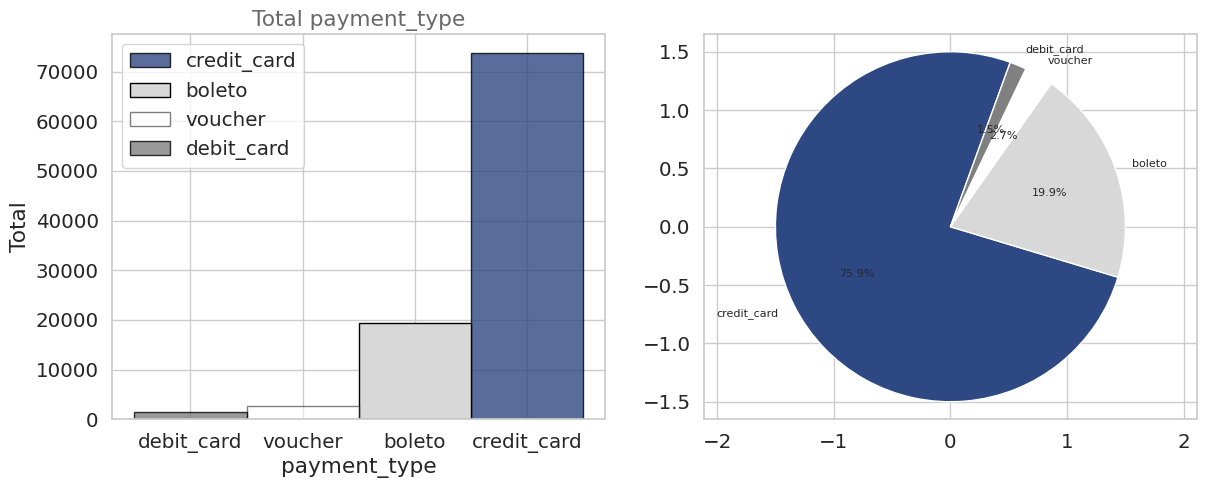

In [35]:
%matplotlib inline
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total')
plt.xlabel('payment_type')
plt.title('Total payment_type',color='dimgrey')
plt.xticks([10,10.25,10.50,10.75],['debit_card','voucher','boleto','credit_card'])
#creating bar plots
plt.bar(10.75,73816, color = '#2e4884', width = 0.25,alpha=0.8,label='credit_card',edgecolor='black')
plt.bar(10.50,19345, color = '#d8d8d8', width = 0.25,label='boleto',edgecolor='black')
plt.bar(10.25,2604, color = 'white', width = 0.25,alpha=0.5,label='voucher',edgecolor='black')
plt.bar(10,1490, color = 'grey', width = 0.25,alpha=0.8,label='debit_card',edgecolor='black')



plt.legend()

plt.subplot(1,2,2)
s= [ 73816,19345, 2604,1490]
new = ['credit_card','boleto','voucher','debit_card']

explode = (0, 0, 0,0)
colours = {'credit_card': '#2e4884',
           'boleto': '#d8d8d8',
           'voucher': 'w',
           'debit_card': 'grey'}

color ={'#2e4884','grey','#d8d8d8','w'}



plt.pie(s, explode=explode, labels=new,colors=[colours[key] for key in new] , autopct='%1.1f%%',shadow=False, startangle=70,radius=1.5,frame=True,textprops={'fontsize': 8})
plt.axis('equal')
plt.show()

Obsrervation(s):

Note: **Baleto** ==> Boleto Bancário, simply referred to as Boleto (English: Ticket) is a payment method in Brazil regulated by FEBRABAN, short for Brazilian Federation of Banks.It can be paid at ATMs, branch facilities and internet banking of any Bank, Post Office, Lottery Agent and some supermarkets until its due date.
* from the above plots we can observe that most of the orders are paid using credit card and the second most used payment method is boleto.

* The percentage of each mode of payment is shown in pie chart which shows amonst the all payments made by the user the credit card is used by 75.9% of the users, baleto is used by 19.9% of the user and 3.2% of the user used voucher and debit card.


In [36]:
temp = pd.DataFrame(df.groupby('payment_type')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
temp['total'] = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp['Avg']   = list(pd.DataFrame(df.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
#sorting dataframe
temp = temp.sort_values(by=['total'], ascending=True)

In [37]:
#Simplifing the plots using pareto plots
def pareto_plot(df, x=None, y=None, title=None, show_pct_y=False, pct_format='{0:.0%}'):
    xlabel = x
    ylabel = y
    tmp = df.sort_values(y, ascending=False)
    x = tmp[x].values
    y = tmp[y].values
    weights = y / y.sum()
    cumsum = weights.cumsum()

    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.bar(x, y,color='#2e4884',edgecolor='black',alpha=0.9)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    ax2 = ax1.twinx()
    ax2.plot(x, cumsum, '-ro', alpha=0.5,color='black')
    ax2.set_ylabel('', color='r')
    ax2.tick_params('y', colors='r')

    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

    # hide y-labels on right side
    if not show_pct_y:
        ax2.set_yticks([])

    formatted_weights = [pct_format.format(x) for x in cumsum]
    for i, txt in enumerate(formatted_weights):
        ax2.annotate(txt, (x[i], cumsum[i]),fontsize=15)

    if title:
        plt.title(title,color='dimgrey',fontsize=15)

    plt.tight_layout()
    plt.show()

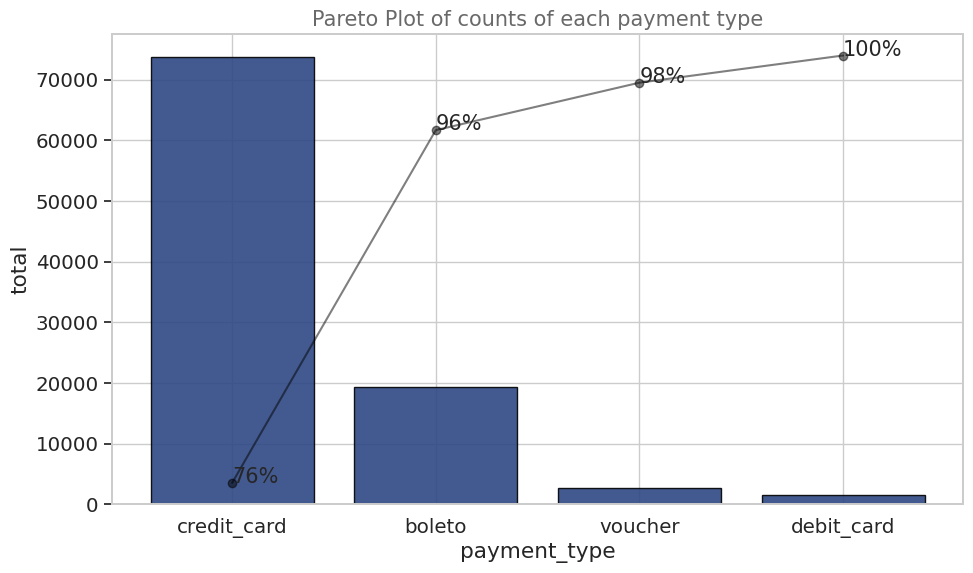

In [38]:
pareto_plot(temp,x='payment_type',y='total',title="Pareto Plot of counts of each payment type")

* we can observe from the above plots that 96 % of the user used credit card and boleto.With credit card , boleto and voucher it covers 98% of users. Now let us see,how it is related with the target variable i.e review score.Or we can say 98% chance that the customer will use credit_card or boleto or voucher.

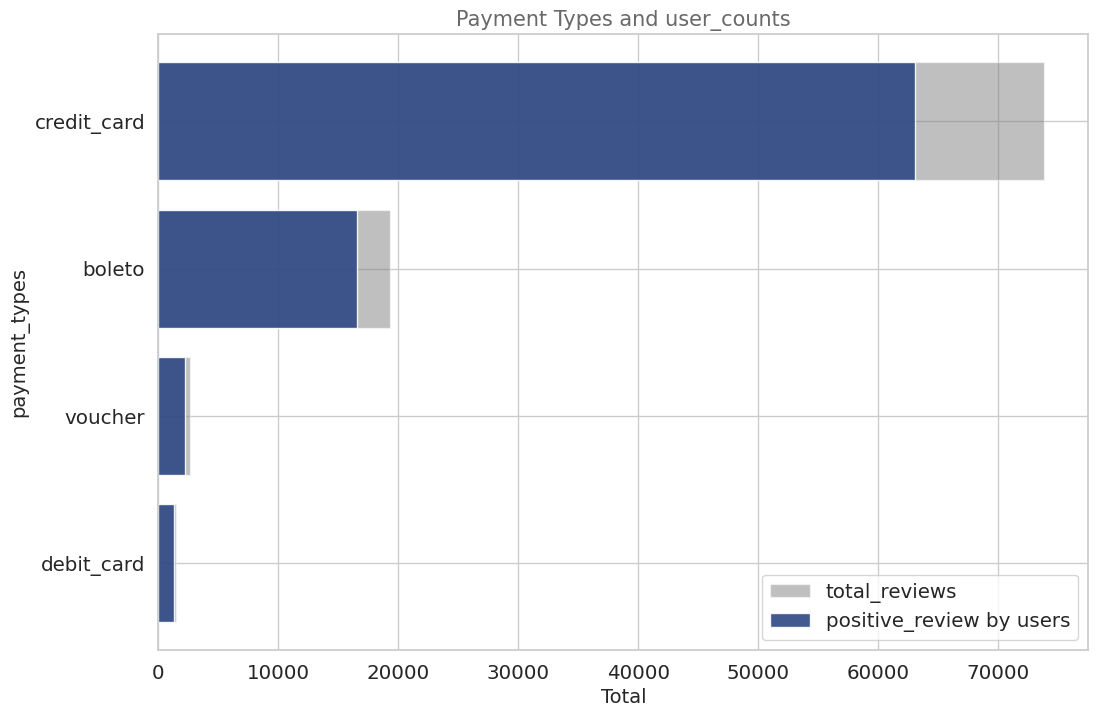

In [39]:
#Let us see how this categorical feature related with our target variable
#code source-https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(12,8))
p1=plt.barh(temp.payment_type,temp.total,color='grey',alpha=0.5)
p2=plt.barh(temp.payment_type,temp.review_score,color='#2e4884',alpha=0.9)
plt.title('Payment Types and user_counts',fontsize=15,color='dimgrey')
plt.ylabel('payment_types',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review by users'))

plt.show()

 Observation(s):

* We can observe from the above stacked plot that most of the customer who used credit card have given positive reviews.Also, for the boleto, voucher and the debit card user it is same.From this we can conclude that this can be our important categorical feature for the problem.





##3.2.2 Customer count based on State wise

![alt text](https://st4.depositphotos.com/1374738/23094/v/950/depositphotos_230940566-stock-illustration-map-brazil-divisions-states.jpg)

[link text](https://)
- Image Source : https://st4.depositphotos.com/1374738/23094/v/950/depositphotos_230940566-stock-illustration-map-brazil-divisions-states.jpg

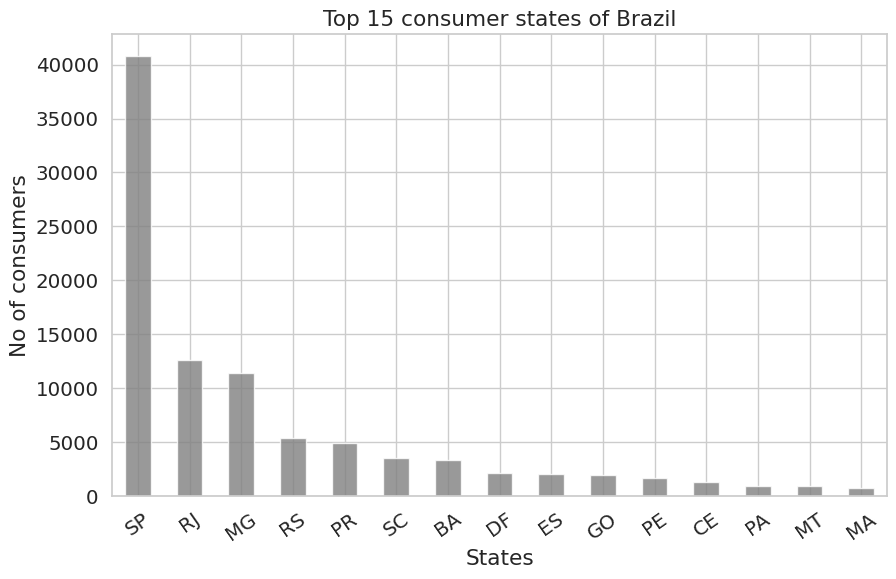

In [40]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.customer_state.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer states of Brazil")
ax.set_xlabel("States")
plt.xticks(rotation=35)
ax.set_ylabel("No of consumers")
plt.show()

Observation(s):

* 42% of total consumers are from the SP(São Paulo), 12.9 % are from RJ(Rio de Janeiro) and 11.7 % are from MG(Minas Gerais) which means most of consumers are from these states.Also from the above map we can observe these are neighbouring staes these staes are most active.Now, Let us see what type of reviews are given from the consumer of these states.




In [41]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2, col3='total'):
    ind = np.arange(data.shape[0])

    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values,color = 'grey',alpha=0.5)
    p2 = plt.bar(ind, data[col2].values,color= '#2e4884',alpha=0.8)

    plt.ylabel('Reviews')
    plt.title('% of review_score  ')
    plt.xticks(ind-0.1, list(data[xtick].values), rotation=0)
    plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review'))
    plt.show()

In [42]:
# Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
temp_1 = pd.DataFrame(df.groupby('customer_state')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


temp_1['total'] = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_1['Avg']   = list(pd.DataFrame(df.groupby('customer_state')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_1= temp_1.rename(columns={'review_score':'positive_review'})
temp_1= temp_1.sort_values(by=['total'], ascending=False)

In [43]:
temp_1

customer_state  positive_review  total       Avg
25             SP            35791  40800  0.877230
18             RJ             9968  12569  0.793062
10             MG             9875  11375  0.868132
22             RS             4650   5351  0.868996
17             PR             4325   4928  0.877638
23             SC             3039   3554  0.855093
4              BA             2677   3314  0.807785
6              DF             1784   2094  0.851958
7              ES             1699   2008  0.846116
8              GO             1670   1959  0.852476
15             PE             1355   1630  0.831288
5              CE             1060   1312  0.807927
13             PA              762    951  0.801262
12             MT              766    891  0.859708
9              MA              569    730  0.779452
11             MS              603    700  0.861429
14             PB              435    523  0.831740
16             PI              395    486  0.812757
19             RN              406    476  0.852941
1              AL              309    407  0.759214
24             SE              270    343  0.787172
26             TO              238    275  0.865455
20             RO              210    242  0.867769
2              AM              125    146  0.856164
0              AC               66     79  0.835443
3              AP               63     68  0.926471
21             RR               33     44  0.750000

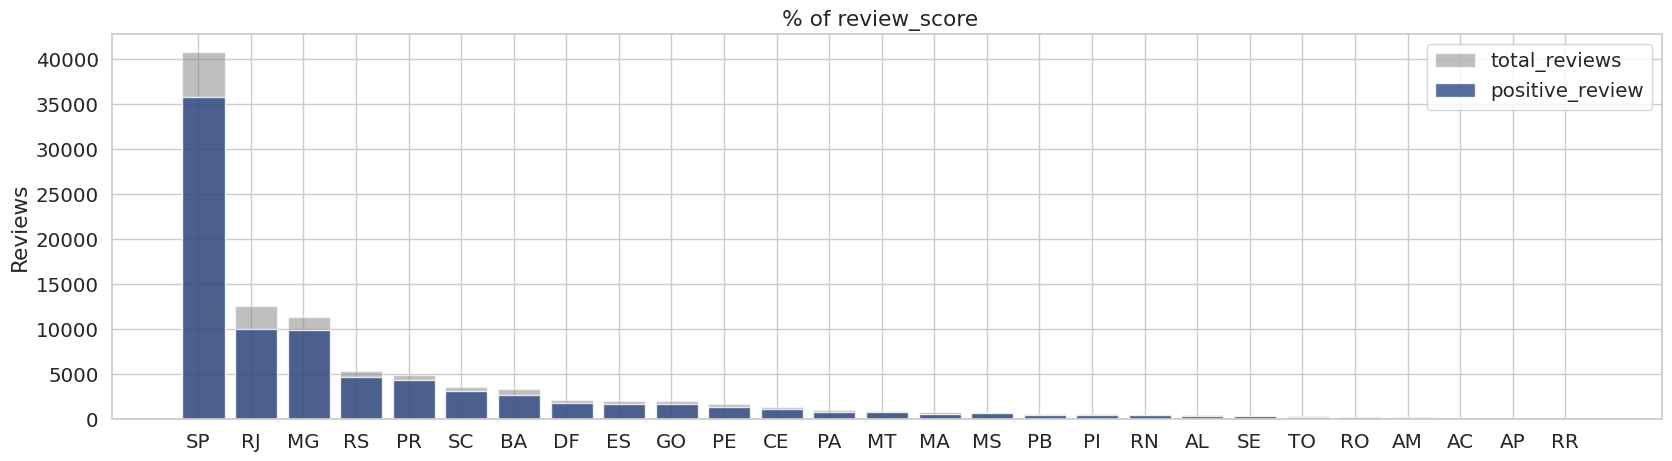

In [44]:
stack_plot(temp_1,'customer_state',col2='positive_review', col3='total')

Observation(s):

* From the avove stack plot of reviews per state we can conclude that most of consumers from each state has given positive reviews.In **SP** state from the total reviews of 40800 , 35791 reviews are positive reviews and for **RJ** state 9968 reviews are positive from the total reviews 12569.The consumer_state can be our important feature for the problem.



## 3.2.2 Univariate Analysis: product_category_name_english

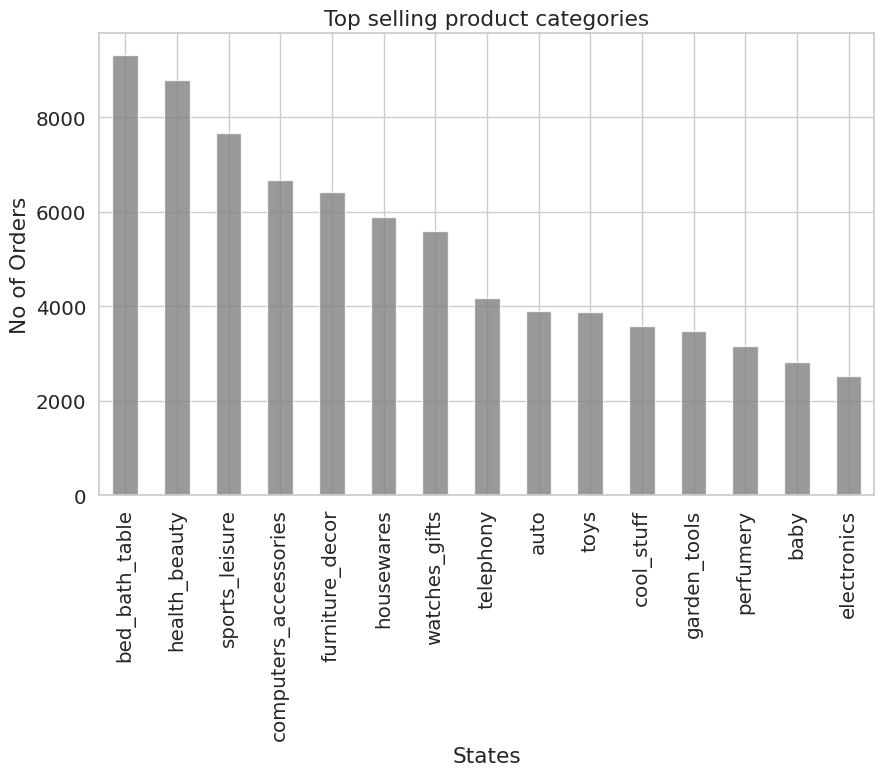

In [45]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = df.product_category_name_english.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("States")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

In [46]:
  temp_2 = pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

  # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


  temp_2['total'] = list(pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
  temp_2['Avg']   = list(pd.DataFrame(df.groupby('product_category_name_english')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
  temp_2 = temp_2.sort_values(by=['total'], ascending=True)
  temp_2

product_category_name_english  review_score  total       Avg
61         security_and_services             1      2  0.500000
29     fashion_childrens_clothes             5      6  0.833333
52                    la_cuisine            10     11  0.909091
11             cds_dvds_musicals            12     12  1.000000
3          arts_and_craftmanship            19     21  0.904762
..                           ...           ...    ...       ...
39               furniture_decor          5327   6417  0.830139
15         computers_accessories          5584   6667  0.837558
65                sports_leisure          6656   7664  0.868476
43                 health_beauty          7653   8797  0.869956
7                 bed_bath_table          7725   9314  0.829397

[71 rows x 4 columns]

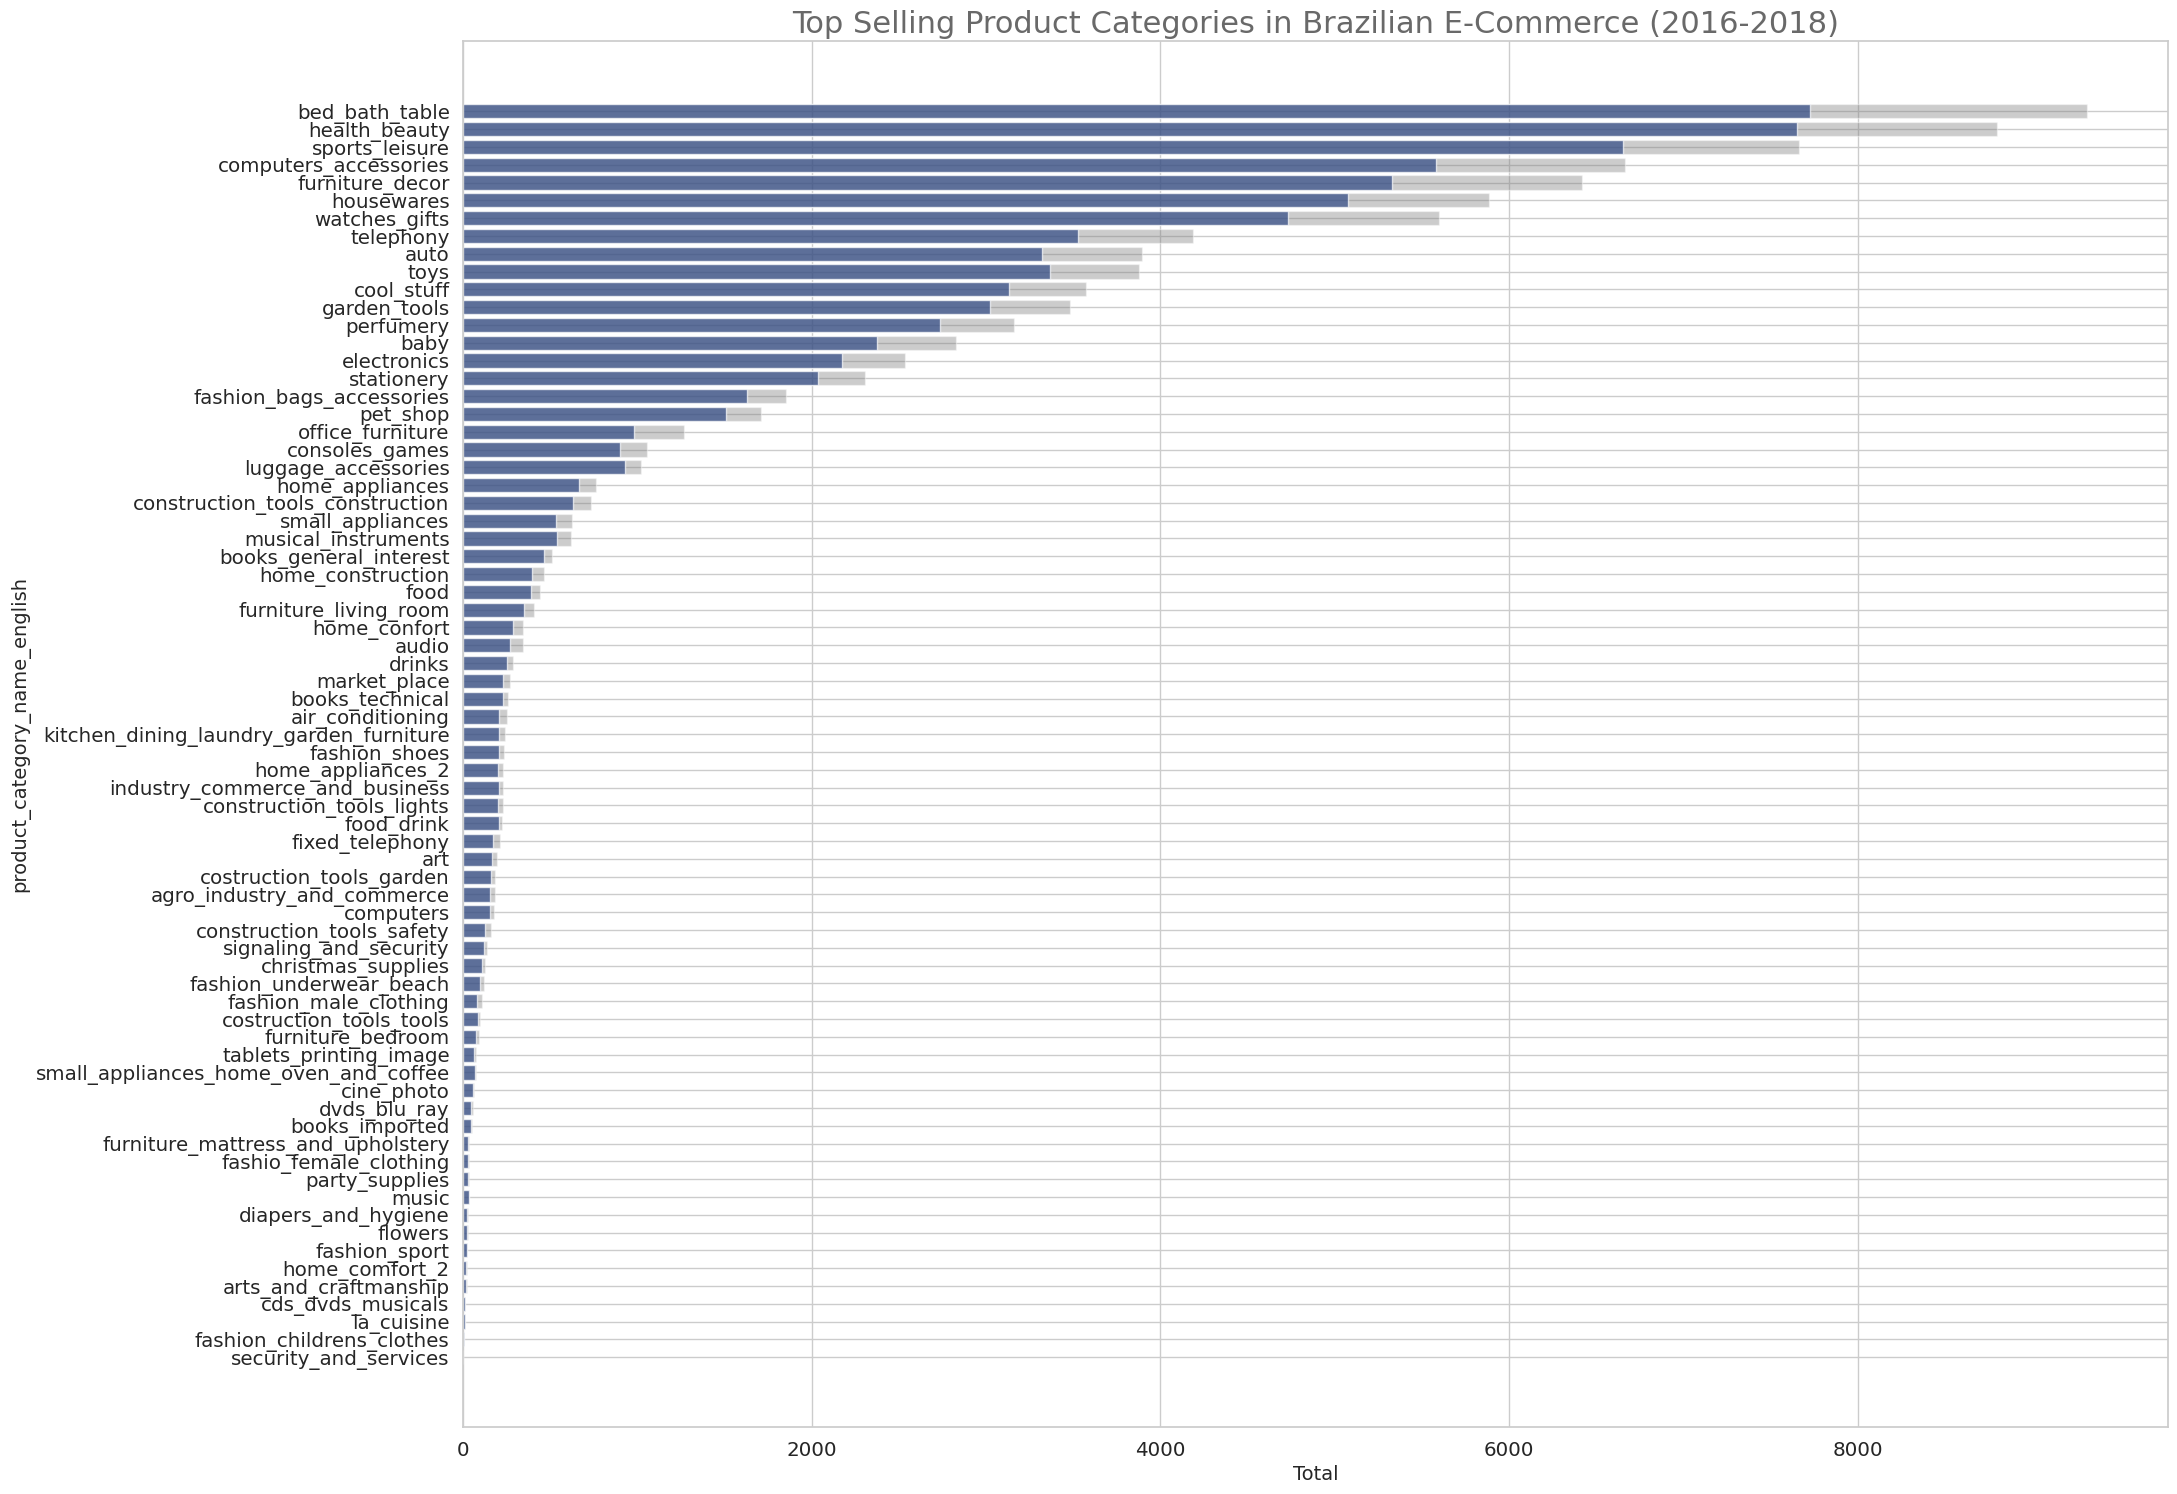

In [47]:
#code source-https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html
plt.figure(figsize=(22,18))
plt.barh(temp_2.product_category_name_english,temp_2.total,color='grey',alpha=0.4)
plt.barh(temp_2.product_category_name_english,temp_2.review_score,color='#2e4884',alpha=0.7)
plt.title('Top Selling Product Categories in Brazilian E-Commerce (2016-2018)',fontsize=22,color='dimgrey')
plt.ylabel('product_category_name_english',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.savefig('plot14.png', dpi=480, bbox_inches='tight')
plt.show()

Observation(s):
* From the first plot titled  Top selling product categories we can conclude that most ordered products is from bed_bath_table category ,health beauty and sports_leisure between 2016 and 2018.The least ordered products are from security_and_services.

* The second plot is stack plot which shows the total reviews and the reviews with positive sense.from this plot we can conclude that most of the reviews for the product category bed_bath_table are positive and it is same for the other product categories.This can be our important categorical feature for the problem.

###3.2.2.frequency of orders Vs Number of Consumers

Text(0.5, 1.0, 'Number of orders per customer')

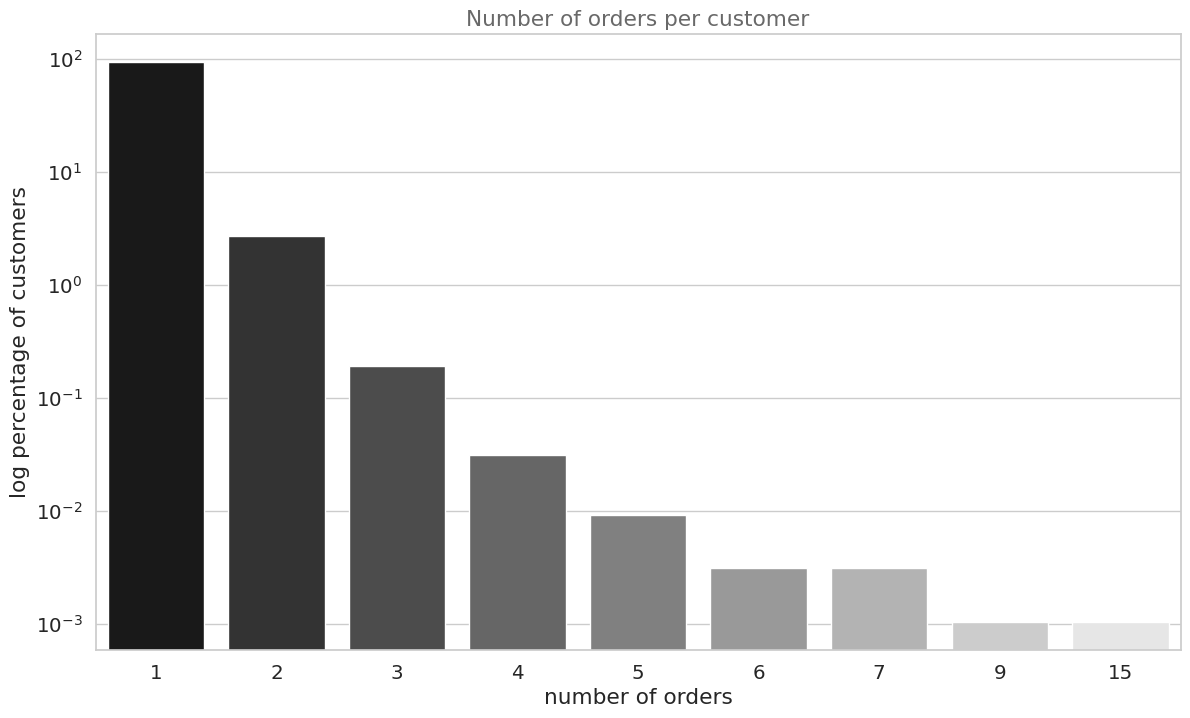

In [48]:
# plotting frequency orders vs  the number of consumers
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
num_orders=df['customer_unique_id'].value_counts().value_counts()/df.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='gray')
plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

Observation(s):
* Most of the consumer given order of any  products only for  one times and few consumers are also present who oredred products more than 35 times. From this we can say order frequecy can be used as important feature for the problem.

### 3.2.2  Order_status

In [49]:
def perform_univariate_analysis(data, column):
    # Perform univariate analysis on the specified column
    column_counts = data[column].value_counts()
    print(column_counts)

    total_count = len(data[column])
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.countplot(data=data, x=column, ax=ax, palette=['grey'])

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f'{height}\n{height/total_count:.2%}', ha="center", fontsize=12, color='black')

    plt.title(f'{column} Analysis', color='dimgrey')
    plt.show()

delivered      95126
shipped         1082
canceled         445
invoiced         305
processing       289
unavailable        6
approved           2
Name: order_status, dtype: int64


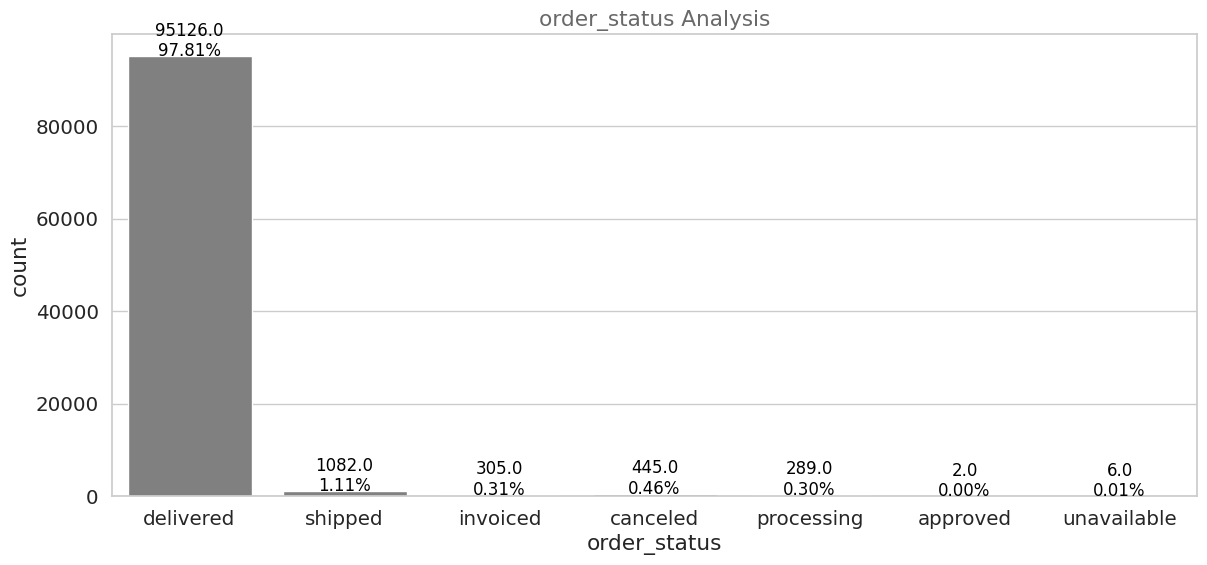

In [50]:
# Perform univariate analysis on 'order_status'
perform_univariate_analysis(df, column='order_status')

In [51]:
def perform_univariate_analysis(data, column):
    # Perform univariate analysis on the specified column
    column_counts = data[column].value_counts()
    print(column_counts)

    total_count = len(data[column])
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.countplot(data=data, x=column, ax=ax, palette=['grey', '#425a90'], hue='review_score')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f'{height}\n{height/total_count:.2%}', ha='center', fontsize=12, color='black')

    plt.title(f'{column} with % of Reviews', color='dimgrey')
    plt.show()

delivered      95126
shipped         1082
canceled         445
invoiced         305
processing       289
unavailable        6
approved           2
Name: order_status, dtype: int64


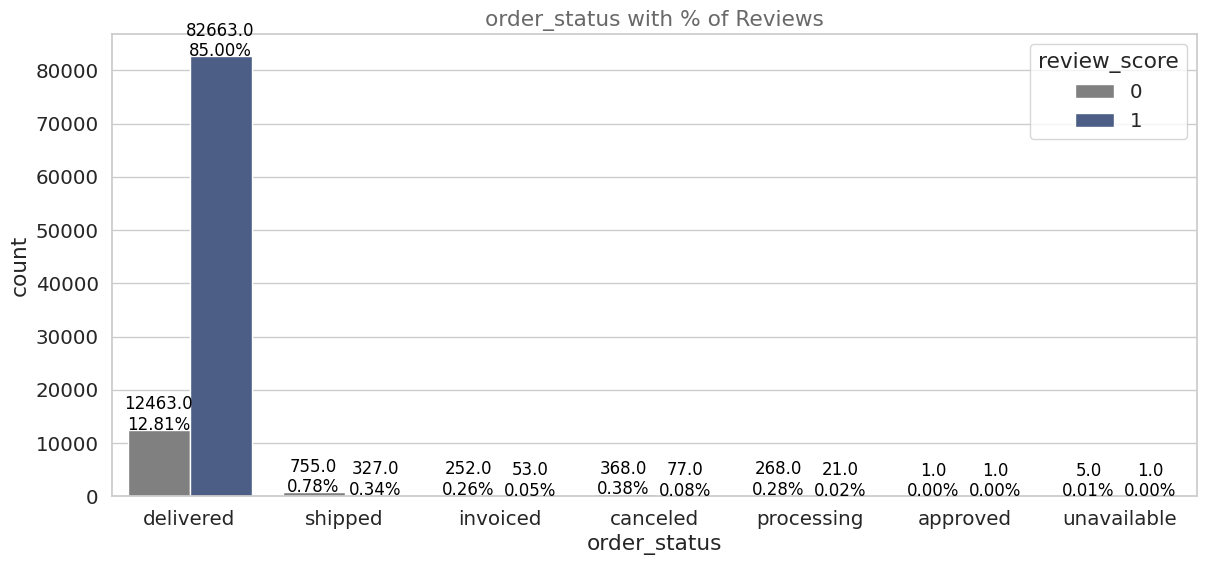

In [52]:
# Perform univariate analysis on 'order_status'
perform_univariate_analysis(df, column='order_status')

Observation(s):

* The first plot shows that 97.8% of the orders of status delivered and remaining precentage are with status shipped,canceled,invoiced,processing,unavailable and approved.

* The second plot shows that for the order_status delivered most of the order are with positive reviews i.e 85% and only 12.8% are negative reviews.

##3.2.2 different Timestamps

In [53]:
#calulating number of days for the data is taken
print(df.order_approved_at.max() - df.order_approved_at.min(), ' from ',
      df.order_approved_at.min(), ' to ', df.order_approved_at.max())

699 days 07:56:34  from  2016-10-04 09:43:32  to  2018-09-03 17:40:06


In [54]:
#code source-https://stackoverflow.com/questions/25146121/extracting-just-month-and-year-separately-from-pandas-datetime-column

# Extracting attributes for purchase date - Year and Month
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year) #gives year Example :2016-10-04 09:43:32 ---->2016
df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month) #gives month Example :2016-10-04 09:43:32 ---->10
df['order_purchase_month_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))#gives month in short form Example :2016-10-04 09:43:32 ---->10--> Oct
df['order_purchase_year_month'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))#gives month&year Example :2016-10-04 09:43:32 ---->201610
df['order_purchase_date'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))#gives month,yr and date  Example :2016-10-04 09:43:32 ---->20161004
df['order_purchase_month_yr'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime("%b-%y"))

# Extracting attributes for purchase date - Day and Day of Week
df['order_purchase_day'] = df['order_purchase_timestamp'].apply(lambda x: x.day)
df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df['order_purchase_dayofweek_name'] = df['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df['order_purchase_hour'] = df['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df['order_purchase_time_day'] = pd.cut(df['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  128e10d95713541c87cd1a2e48201934  a20e8105f23924cd00833fd87daa0831   
4  0e7e841ddf8f8f2de2bad69267ecfbcf  26c7ac168e1433912a51b924fbd34d34   
5  bfc39df4f36c3693ff3b63fcbea9e90a  53904ddbea91e1e92b2b3f1d09a7af86   
6  6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2017-08-15 18:29:31 2017-08-15 20:05:16   
4    delivered      2017-08-02 18:24:47 2017-08-02 18:43:15   
5    delivered      2017-10-23 23:26:46 2017-10-25 02:14:11   
6    delivered      2017-11-24 21:27:48 2017-11-25 00:21:09   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-10-10 21:25:13                    2017-10-18   
3           2017-08-18 14:44:43                    2017-08-28   
4           2017-08-07 18:30:01                    2017-08-15   
5           2017-11-07 18:04:59                    2017-11-13   
6           2017-12-28 18:59:23                    2017-12-21   

   payment_sequential payment_type  payment_installments  payment_value  \
0                   1  credit_card                     1          18.12   
3                   1  credit_card                     3          37.77   
4                   1  credit_card                     1          37.77   
5                   1       boleto                     1          44.09   
6                   1  credit_card                    10         356.12   

                 customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
3  3a51803cc0d012c3b5dc8b7528cb05f7                      3366   
4  ef0996a1a279c26e7ecbd737be23d235                      2290   
5  e781fdcc107d13d865fc7698711cc572                     88032   
6  3e4fd73f1e86b135b9b121d6abbe9597                     19400   

          customer_city customer_state  order_item_id  \
0             sao paulo             SP              1   
3             sao paulo             SP              1   
4             sao paulo             SP              1   
5         florianopolis             SC              1   
6  presidente venceslau             SP              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
4  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
5  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
6  be021417a6acb56b9b50d3fd2714baa8  f5f46307a4d15880ca14fab4ad9dfc9b   

   shipping_limit_date   price  freight_value  product_category_name  \
0  2017-10-06 11:07:15   29.99           8.72  utilidades_domesticas   
3  2017-08-21 20:05:16   29.99           7.78  utilidades_domesticas   
4  2017-08-08 18:37:31   29.99           7.78  utilidades_domesticas   
5  2017-10-31 02:14:11   29.99          14.10  utilidades_domesticas   
6  2017-11-30 00:21:09  339.00          17.12  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       268.0                 4.0   
3                 40.0                       268.0                 4.0   
4                 40.0                       268.0                 4.0   
5                 40.0                       268.0                 4.0   
6                 48.0                       664.0                 6.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             500.0               19.0                8.0              13.0   
3             500.0               19.0                8.0              13.0   
4             500.0               19.0                8.0              13.0   


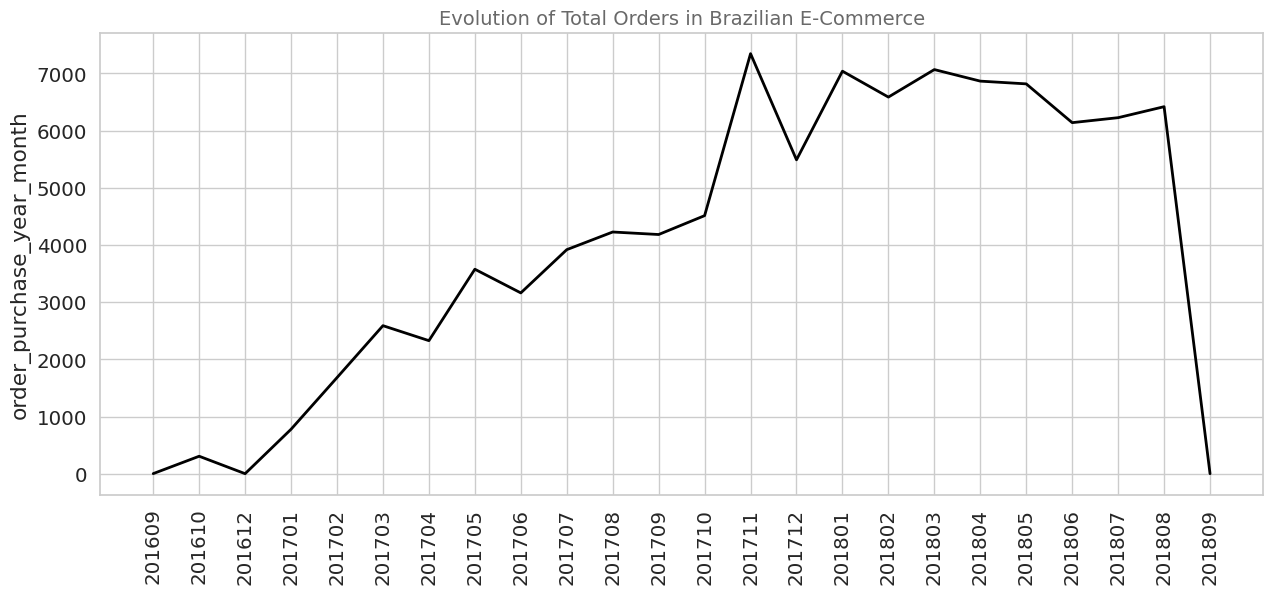

In [55]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df['order_purchase_year_month'].value_counts().sort_index(),
             color='black', linewidth=2)
plt.title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')
plt.xticks(rotation=90)
plt.show()

Observation(s):
* from the above plot we can observe that the number of purchase is increasing from 201609 to 201711(highest) and then decreases for a short sapn which means the either orders from the older customers are increasing or the number of consumers are increasing.

In [56]:
df_month = pd.DataFrame()
df_month['date'],df_month['review_score']= list(df.order_approved_at),list(df.review_score)
df_month=df_month.dropna()
df_month = df_month.sort_values(by=['date'])

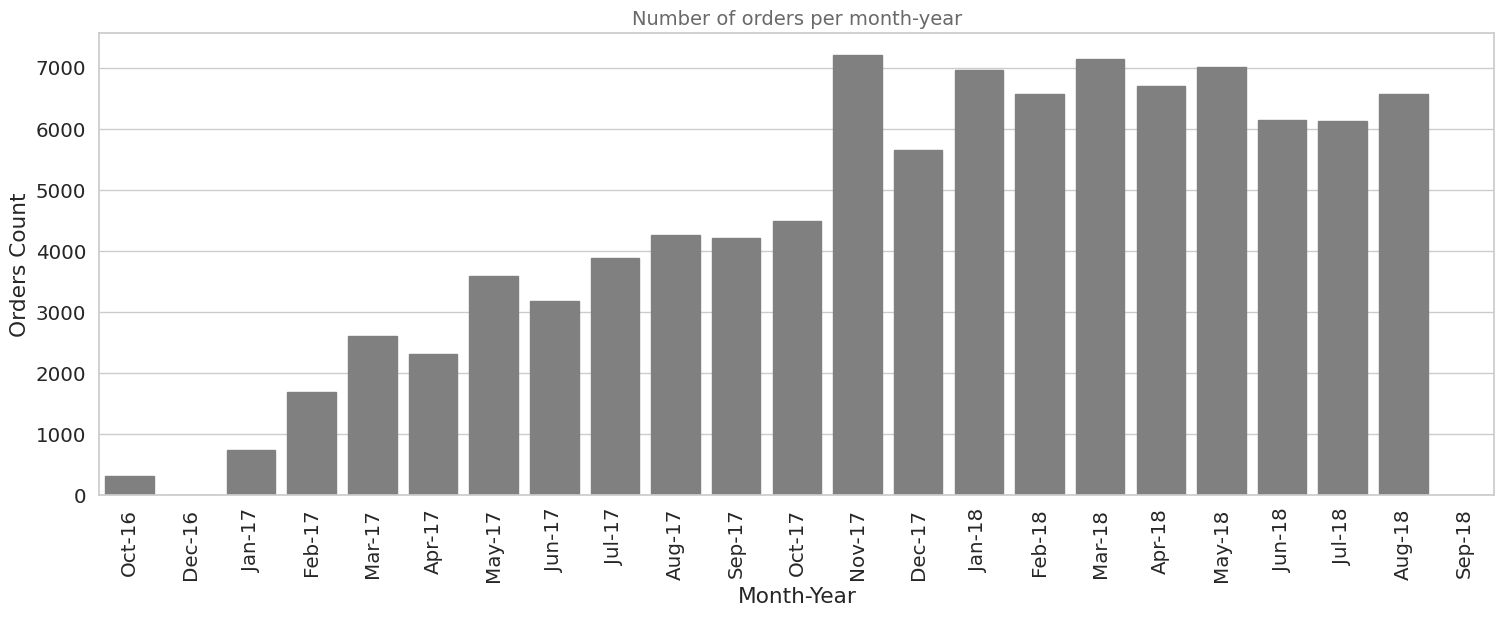

In [57]:
df_month['monthcount'] = list(df_month.date.apply(lambda x: x.strftime("%b-%y")))
#plotting number of orders per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,data=df_month,color='grey',edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of orders per month-year', size=14, color='dimgrey');

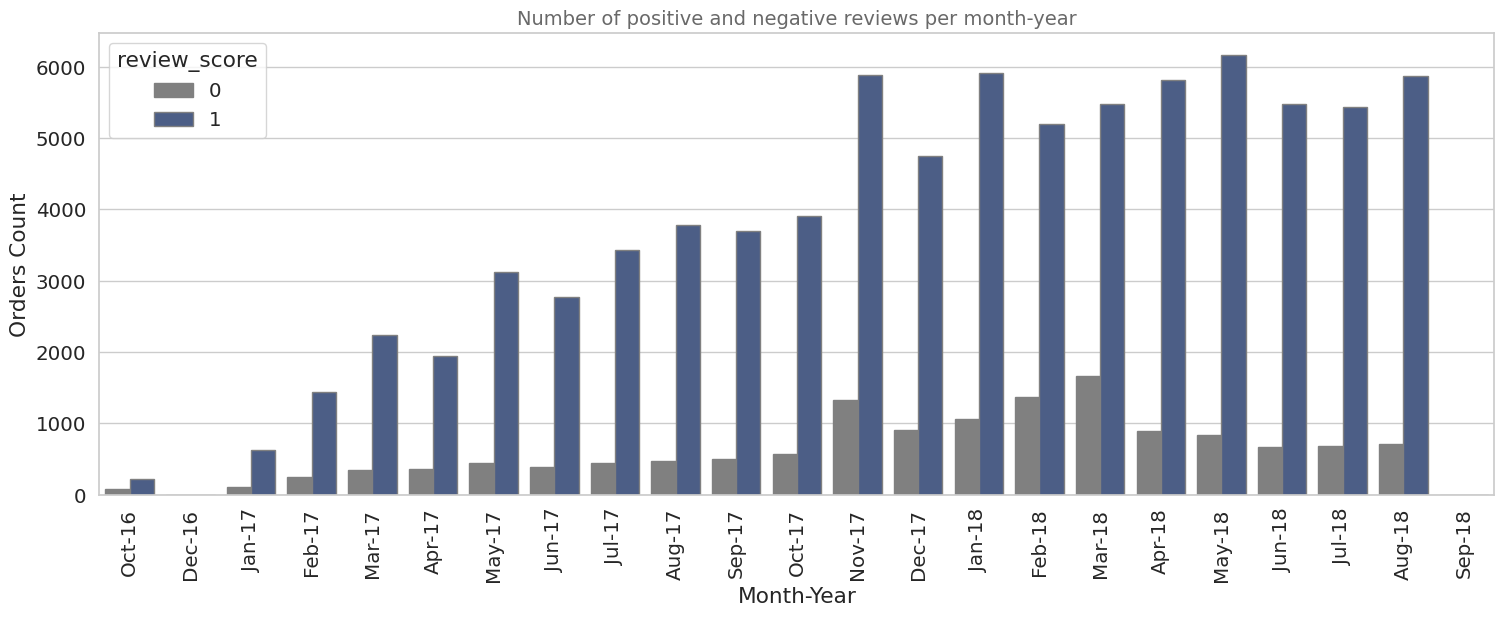

In [58]:
#plotting number of positive and negative reviews per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x=df_month.monthcount,hue='review_score',data=df_month,palette=['grey','#425a90'],edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of positive and negative reviews per month-year', size=14, color='dimgrey');

Observation(s):
* From the first plot titled Number of orders per month-year show the total number order received per month on each each between 2016 and 2018.It can be observeed that in the month of November in the year 2017 the highest number of orders are received which is more the 7000 approx. and the leat number of orders are received in the month of Dec in the year 2016.

* The second plot shows the total number of positive and negative reviews given for each order  per month-year.It can observed that  most the orders have given positive reviews.From the above plot we observed that on NOV-17 the highest orders were received but from the second plot we can see the highest positive reviews were given on May-18

In [59]:
from matplotlib.gridspec import GridSpec

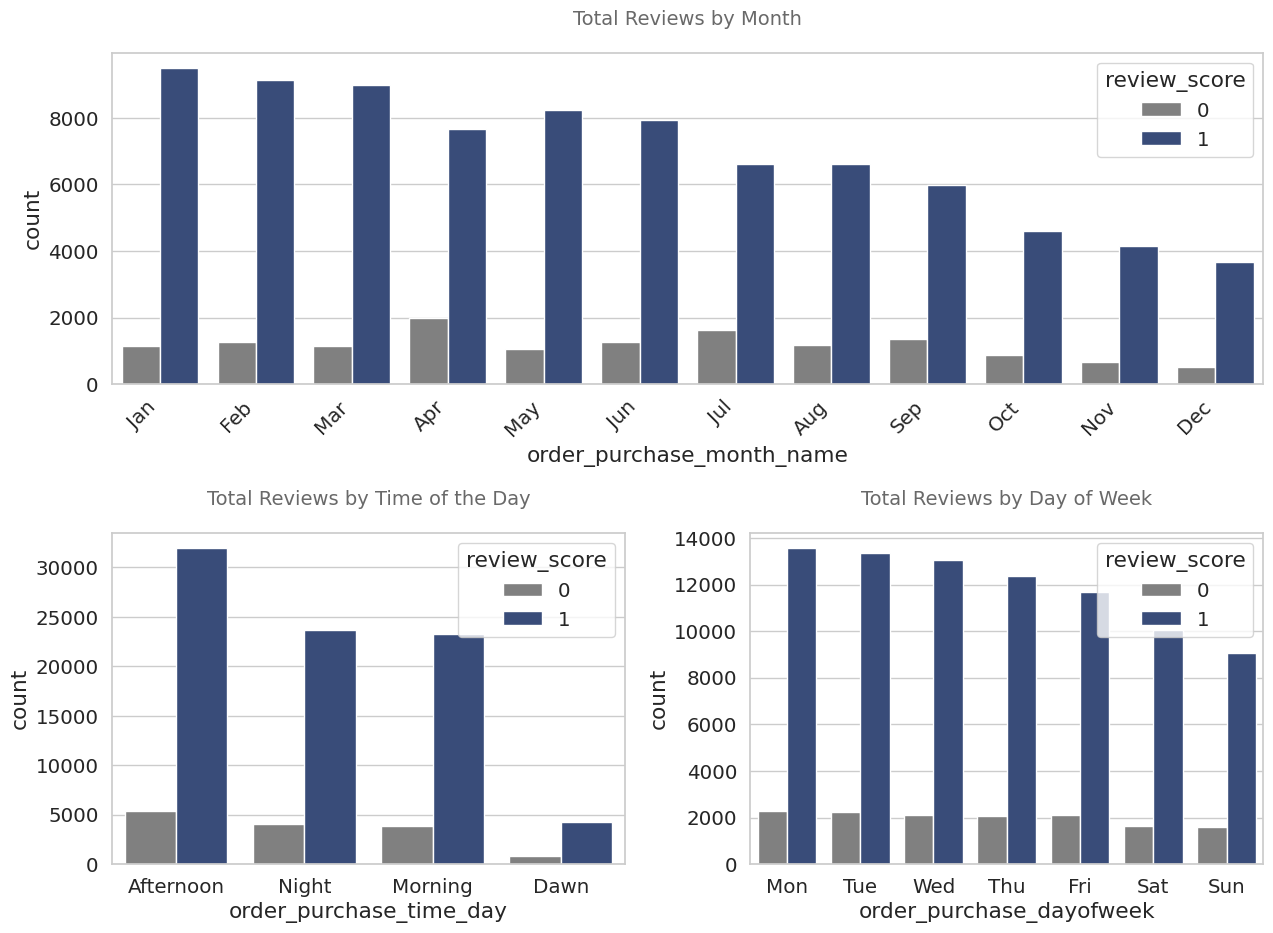

In [60]:
# Create the figure and axes
fig = plt.figure(constrained_layout=True, figsize=(13, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, :])
ax3 = fig.add_subplot(gs[1, 1])

# Barchart - Total Reviews by time of the day
time_of_day_counts = df['order_purchase_time_day'].value_counts()
sns.countplot(data=df, x='order_purchase_time_day', ax=ax1, order=time_of_day_counts.index, palette=['grey', '#2e4884'], hue='review_score')
ax1.set_title('Total Reviews by Time of the Day', size=14, color='dimgrey', pad=20)

# Barchart - Total Reviews by month
month_counts = df['order_purchase_month_name'].value_counts()
sns.countplot(data=df, x='order_purchase_month_name', ax=ax2, order=month_counts.index, palette=['grey', '#2e4884'], hue='review_score')
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, ha='right')
ax2.set_title('Total Reviews by Month', size=14, color='dimgrey', pad=20)

# Barchart - Total Reviews by day of the week
day_of_week_counts = df['order_purchase_dayofweek'].value_counts()
sns.countplot(data=df, x='order_purchase_dayofweek', ax=ax3, order=day_of_week_counts.index, palette=['grey', '#2e4884'], hue='review_score')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax3.set_xticklabels(weekday_label, rotation=0, ha='center')
ax3.set_title('Total Reviews by Day of Week', size=14, color='dimgrey', pad=20)

# Fine-tune the layout
fig.tight_layout(rect=[0, 0, 1, 0.96])

# Save and display the figure
plt.savefig('plot14.png', dpi=300, bbox_inches='tight')
plt.show()

Observation(s):
* From the subplot titled Total Reviews by Month we can observe that the highest % of positive reviews amongst the total reviews between 2016 to 2018 are given on the month of feb i.e 9.8%.In the month of May and July amongst the total reviews there are more than 9.0% reviews are positive.

* From the second subplot titled Total Reviews by Time of the day ,we can conclude that maximum number of orders are received in afternoon and the highest % of positive reviews are given on that time i.e 32.8%.

* From the third subplot titled Total Reviews by day of the week  ,we can conclude that maximum number of orders are received on Monday and the highest % of positive reviews are given on that day  and Tuesday i.e 13.9%.


In [61]:
#ploting plot for the Total Number orders based on the Total delivery Time(Days)
#https://stackoverflow.com/questions/60229375/solution-for-specificationerror-nested-renamer-is-not-supported-while-agg-alo
df['day_to_delivery']=((df['order_delivered_customer_date']-df['order_purchase_timestamp']).dt.days)

In [62]:
df_dev = pd.DataFrame()
df_dev['day_to_delivery'],df_dev['review_score']= list(df.day_to_delivery),list(df.review_score)
df_dev=df_dev.dropna()

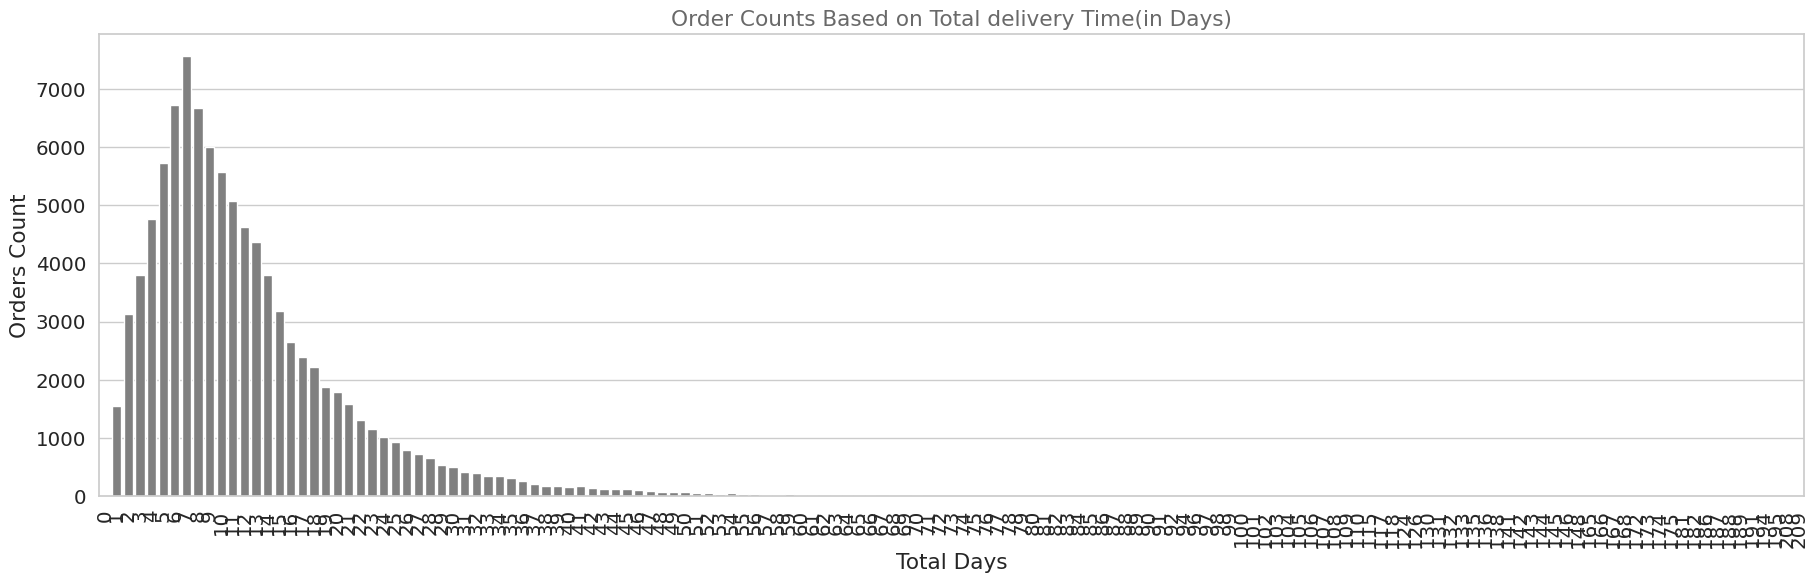

In [63]:
plt.figure(figsize=(22,6))
plt.title('Order Counts Based on Total delivery Time(in Days)', color='dimgrey')
g = sns.countplot(x=df_dev.day_to_delivery,data=df_dev,color='gray')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Total Days')
g.set_ylabel('Orders Count');

Observation(s):
* It can be observed that the maximum number of orders are delivered in 7 days few orders are also delivered in more than 30 days.The total deliver time can be a new feature to solve this problem.

# 3.2.2 Numerical Features
* Price

<Figure size 640x480 with 0 Axes>

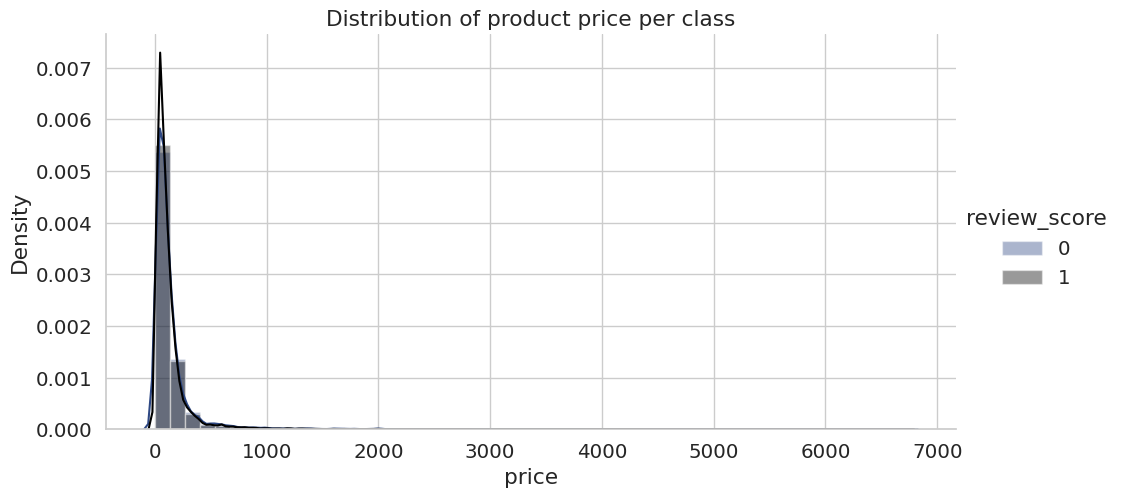

In [64]:
import seaborn as sns

plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "price").add_legend();
plt.title('Distribution of product price per class')
plt.show()

* The above distribution plot shows the distribution of price for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on price feature.

* freight_value

<Figure size 640x480 with 0 Axes>

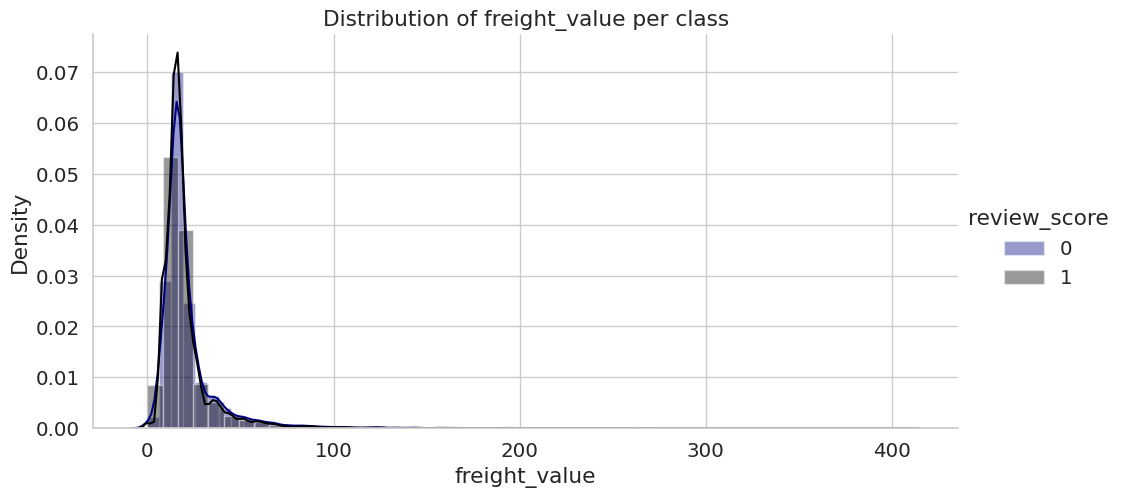

In [65]:
# plotting distributions of freight_value per class
plt.figure()
#sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#000080','black'])
ax = ax.map(sns.distplot, "freight_value").add_legend();
plt.title('Distribution of freight_value per class')
plt.show()

* The above distribution plot shows the distribution of freight_value for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on freight_value feature.

* product_height_cm

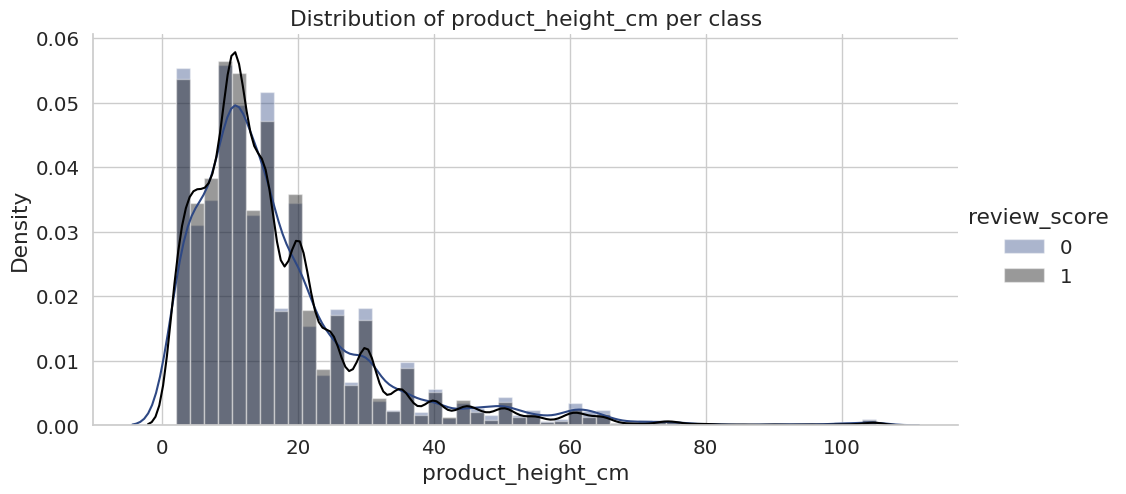

In [66]:
# plotting distributions of product_height_cm per class
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "product_height_cm").add_legend();
plt.title('Distribution of product_height_cm per class')
plt.show()

* The above distribution plot shows the distribution of product_height_cm for both the postive and negative classes. We can observe that most of the product has height less than 20 .Also, there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on product_height_cm feature.

product_weight_g

<Figure size 640x480 with 0 Axes>

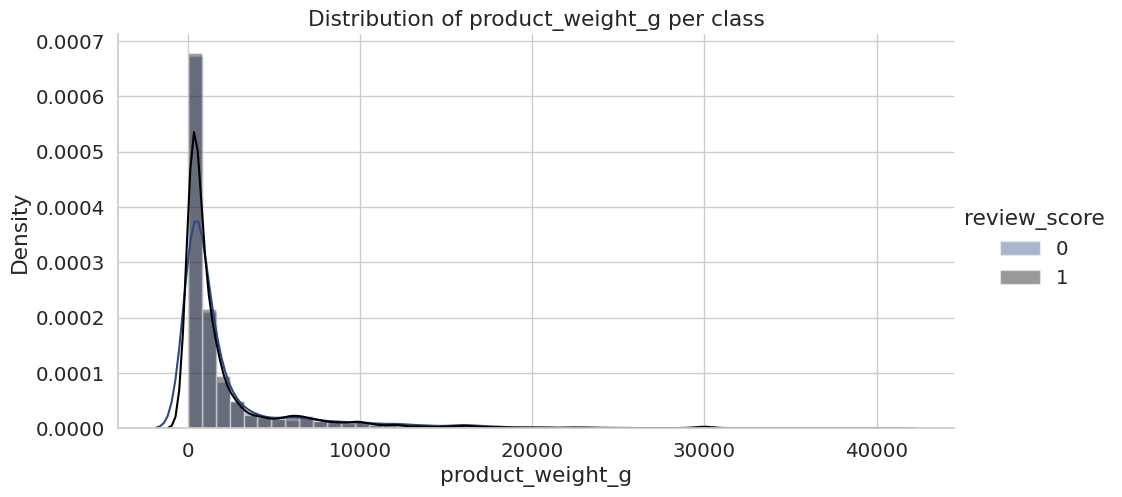

In [67]:

# distriution plot of product_weight_g
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "product_weight_g").add_legend();
plt.title('Distribution of product_weight_g per class')
plt.show()

* The above distribution plot shows the distribution of product_weight_g for both the postive and negative classes. We can observe that most of the product has weight less than 5000 gm .Also, there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on product_weight_g feature.

* payment_value

<Figure size 640x480 with 0 Axes>

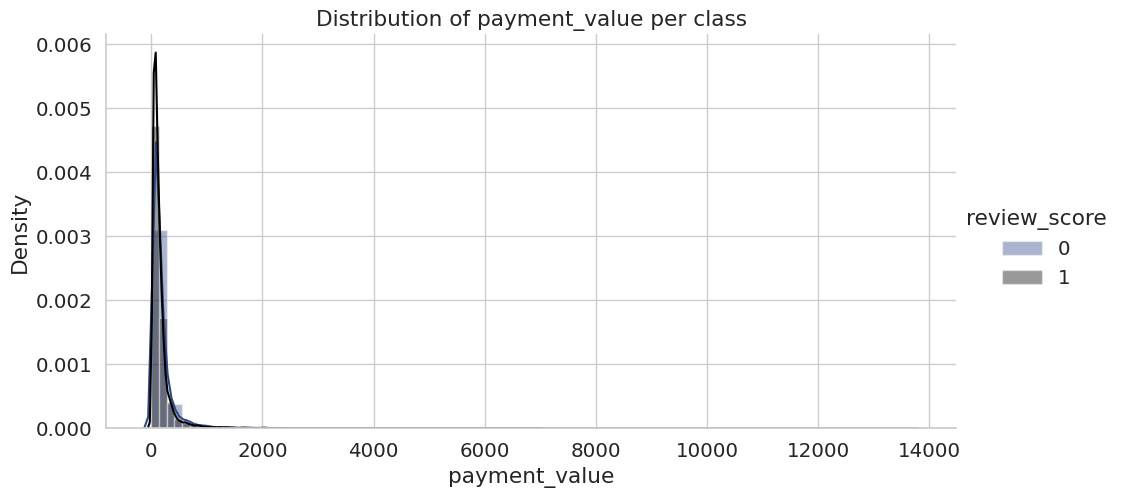

In [68]:
# distriution plot of payment_value
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "payment_value").add_legend();
plt.title('Distribution of payment_value per class')
plt.show()

* The above distribution plot shows the distribution of payment_value for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on payment_value feature.

* Box Plot

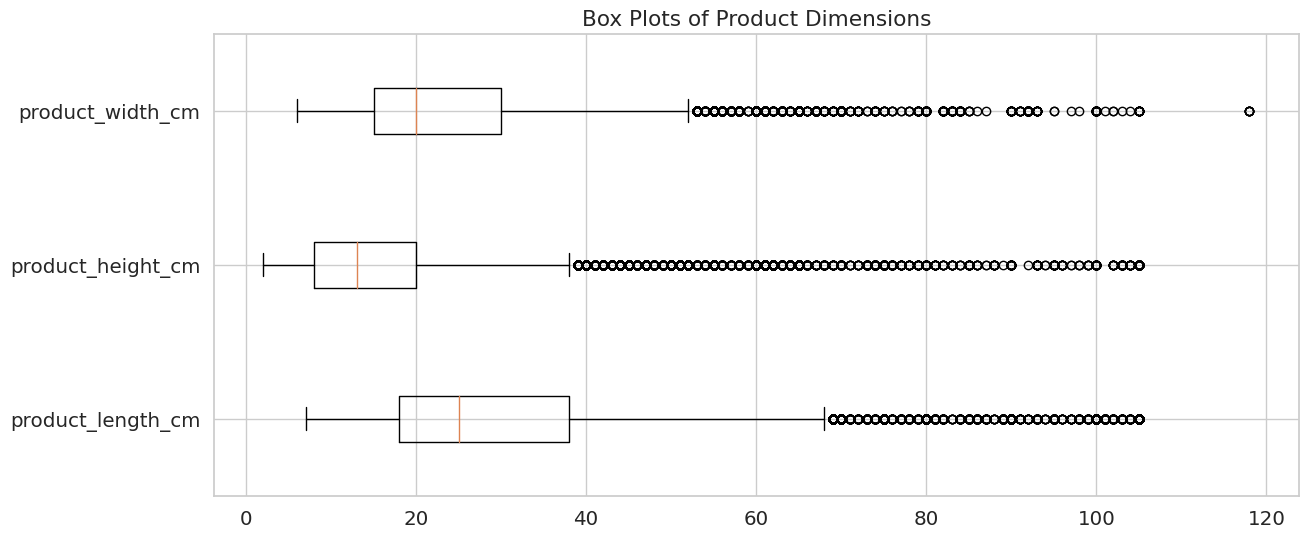

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

box_plot_data=[df.product_length_cm,df.product_height_cm,df.product_width_cm]
plt.boxplot(box_plot_data,labels=['product_length_cm','product_height_cm','product_width_cm'],vert=False)
plt.title("Box Plots of Product Dimensions")
plt.savefig('plot24.png', dpi=400, bbox_inches='tight')
plt.show()

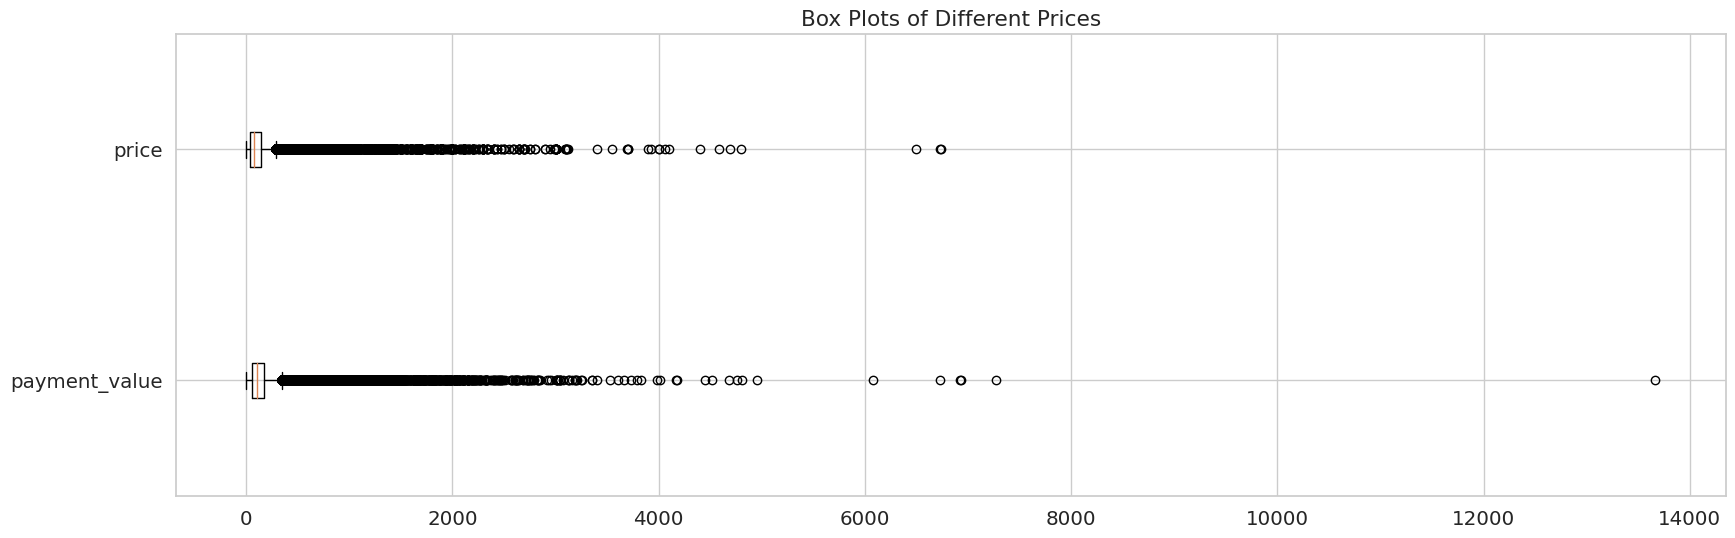

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))

box_plot_data=[df.payment_value,df.price]
plt.boxplot(box_plot_data,labels=['payment_value','price'],vert=False)
plt.title("Box Plots of Different Prices")
plt.savefig('plot25.png', dpi=400, bbox_inches='tight')
plt.show()

* The  above box plots are showing the distribution of  the numerical features product_width_cm, product_height_cm and product_width_cm. These features are overlapping each other.


# 3.2.3.Bivariate Analysis

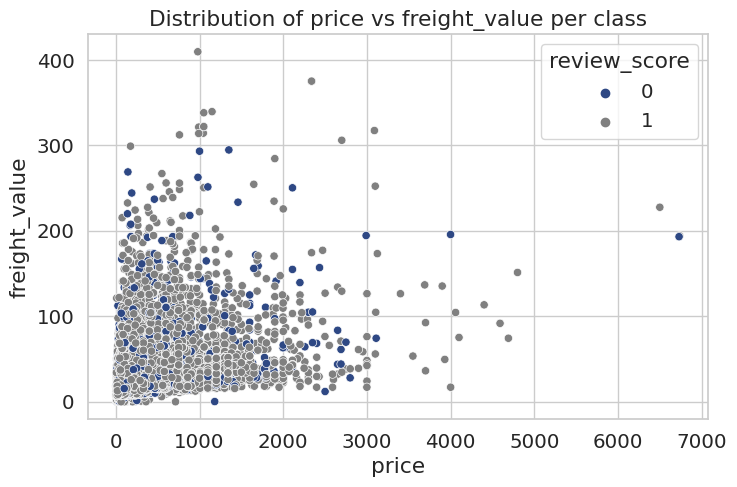

In [71]:

# Distribution of price vs freight_value per class
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(x='price',y='freight_value', data = df, hue="review_score",palette=['#2e4884','grey'])
plt.title('Distribution of price vs freight_value per class')
plt.show()

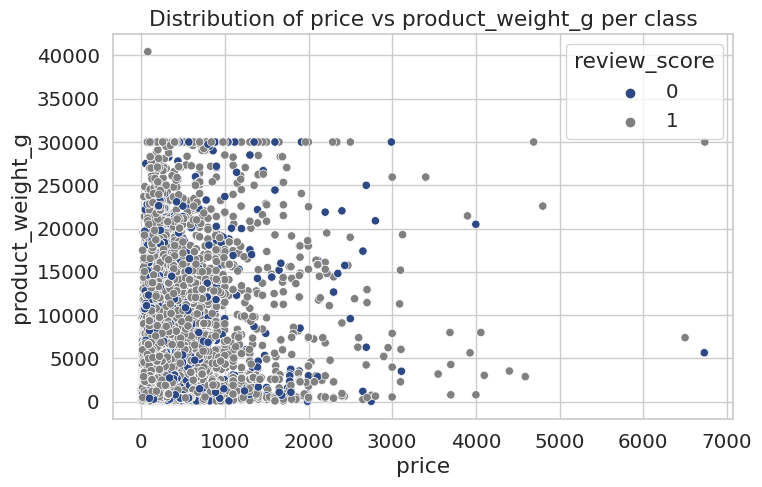

In [72]:

# Distribution of price vs product_weight_g per class
plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
ax = sns.scatterplot(x='price',y='product_weight_g', data = df, hue="review_score",palette=['#2e4884','grey'])
plt.title('Distribution of price vs product_weight_g per class')
plt.show()

Obervation(s):

* From the above two scatter plots titled `Distribution of price vs freight_value per class` and `Distribution of price vs product_weight_g per class` respectively, It is very hard to say anything about the reviews on the basis of these plot as data-points are not seperable based on reviews these are completely mixed data.

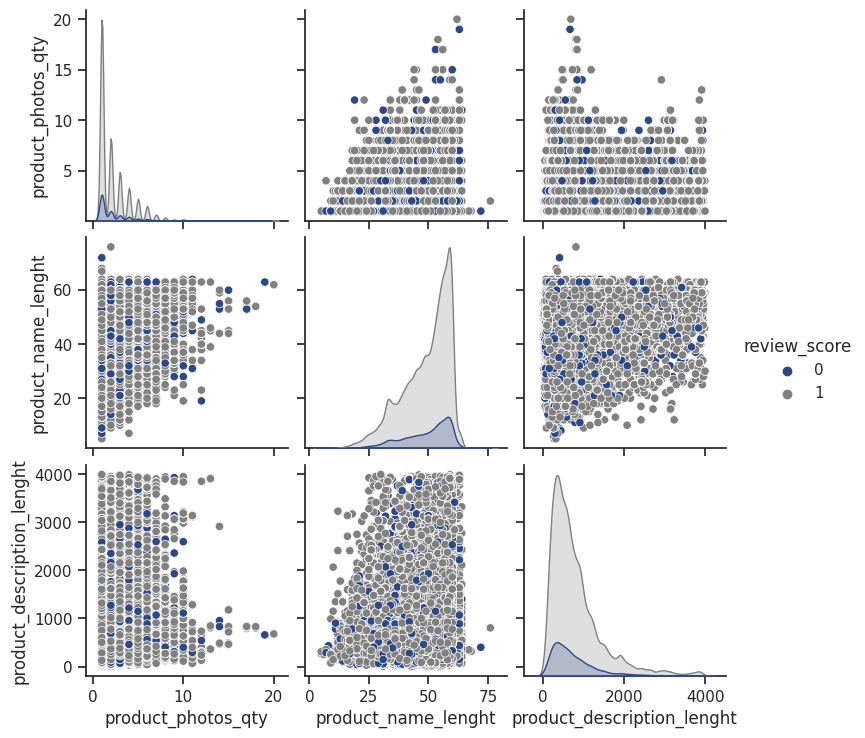

In [73]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
# pair plot
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df[['product_photos_qty','product_name_lenght','product_description_lenght','review_score']],hue='review_score',palette=['#2e4884','grey'])
g.savefig("pairplot1.png")

In [74]:
df_mm=df[['order_purchase_month_name','price']].groupby('order_purchase_month_name').sum()

In [75]:
pi = list(df_mm['price'])
li = list(df_mm.index)
#dict of months and price value
res = {li[i]: pi[i] for i in range(len(li))}

In [76]:
from collections import OrderedDict
mnths = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep','Oct','Nov','Dec']
weeks=['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
res = dict(OrderedDict(sorted(res.items(),key =lambda x:mnths.index(x[0]))))#sorting by month
print(res)

{'Jan': 954974.48, 'Feb': 980856.9, 'Mar': 1226985.73, 'Apr': 1229466.8, 'May': 1345981.59, 'Jun': 1188101.51, 'Jul': 1265033.8, 'Aug': 1304393.96, 'Sep': 554920.17, 'Oct': 629428.18, 'Nov': 894155.17, 'Dec': 676493.39}


In [77]:
temp_3= pd.DataFrame(df.groupby('order_purchase_month_name')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039


temp_3['total'] = list(pd.DataFrame(df.groupby('order_purchase_month_name')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp_3['Avg']   = list(pd.DataFrame(df.groupby('order_purchase_month_name')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
temp_3= temp_3.sort_values(by=['total'], ascending=True)

In [78]:
rem = {list(temp_3.order_purchase_month_name)[i]: list(temp_3.total)[i] for i in range(len(temp_3))}
rem = dict(OrderedDict(sorted(rem.items(),key =lambda x:mnths.index(x[0]))))
print(rem)

{'Jan': 7817, 'Feb': 8267, 'Mar': 9656, 'Apr': 9192, 'May': 10393, 'Jun': 9301, 'Jul': 10144, 'Aug': 10645, 'Sep': 4186, 'Oct': 4819, 'Nov': 7345, 'Dec': 5490}


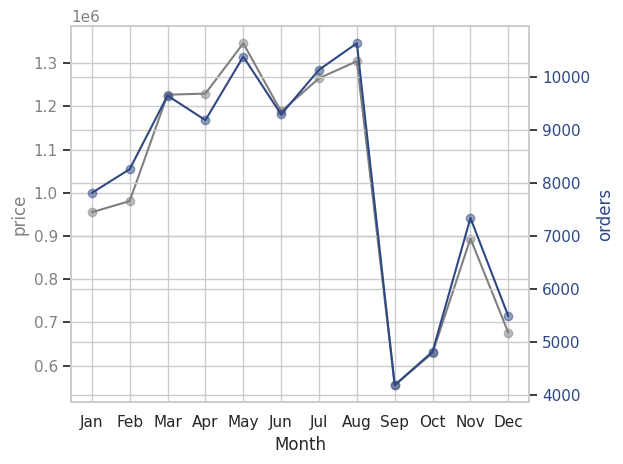

In [79]:
#https://matplotlib.org/2.2.5/gallery/api/two_scales.html
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")


fig, ax1 = plt.subplots()

color = 'grey'
ax1.set_xlabel('Month')
ax1.set_ylabel('price', color=color)
ax1.plot(list(res.keys()),list(res.values()), color=color)
ax1.plot(list(res.keys()),list(res.values()),'C0o', alpha=0.5,color='grey')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = '#2e4884'
ax2.set_ylabel('orders', color=color)  # we already handled the x-label with ax1
ax2.plot(list(res.keys()),list(rem.values()), color=color)
ax2.plot(list(res.keys()),list(rem.values()),'C0o', alpha=0.5,color='#2e4884')
ax2.tick_params(axis='y', labelcolor=color)
#creating  points


fig.tight_layout( )  # otherwise the right y-label is slightly clipped
plt.show()

* from the above plots we can observe that there is same pattern of total sales and the total order per month between 016 and 2018.

# 3.2.5. Text Analysis

In [80]:
oder_review.head()
oder_review.shape

(100000, 7)

In [81]:
df1 = oder_review

In [82]:
review_data_title = df1['review_comment_title']
review_data = df1.drop(['review_comment_title'], axis=1)

# Dropping NaN values
review_data = review_data.dropna()
review_data_title = review_data_title.dropna()



In [83]:
# Resetting the reviews index and visualizing the data
review_data = review_data.reset_index(drop=True)
review_data.head(3)
review_data.shape

(41753, 6)

In [84]:

# Resetting the reviews titles index and visualizing the data
review_data_title = review_data_title.reset_index(drop=True)
review_data_title.head(3)
review_data_title.shape

(11715,)

In [85]:
import nltk


In [86]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [87]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [88]:
comments = []
stop_words = set(stopwords.words('portuguese'))

# Drop NaN values from df1
df1 = df1.dropna(subset=['review_comment_message'])

df1['review_comment_message'] = df1['review_comment_message'].astype(str)

for words in df1['review_comment_message']:
    if words != 'nan':
        only_letters = re.sub("[^a-zA-Z]", " ", words)
        tokens = word_tokenize(only_letters)  # tokenize the sentences
        lower_case = [l.lower() for l in tokens]  # convert all letters to lower case
        filtered_result = [l for l in lower_case if l not in stop_words]  # Remove stopwords from the comments
        comments.append(' '.join(filtered_result))

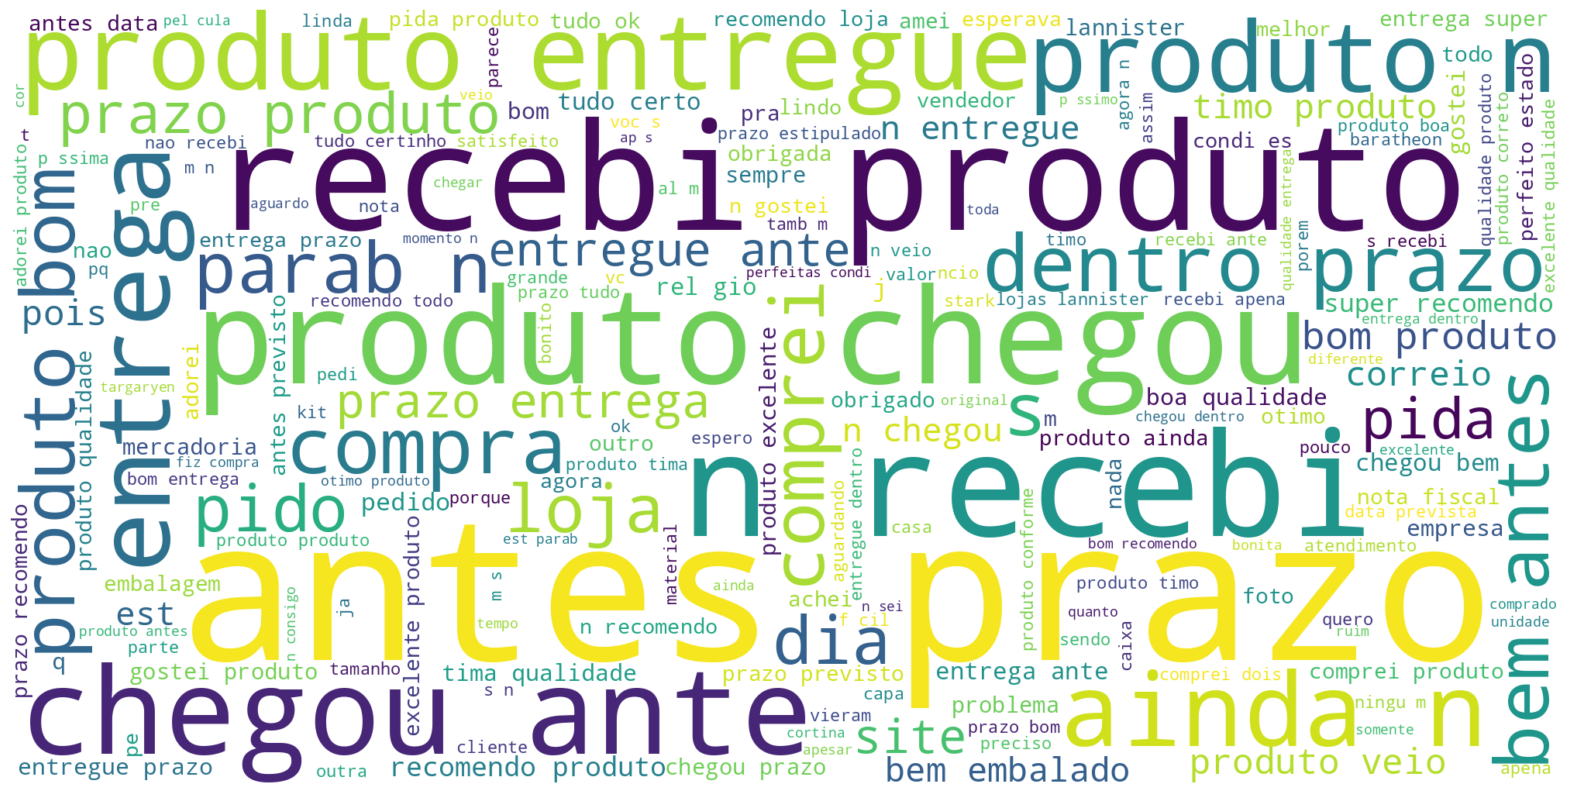

In [89]:
#Using wordcloud to visualize the comments
unique_string=(" ").join(comments)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('plot23.png', dpi=400, bbox_inches='tight')
plt.show()

In [90]:
#further checking by Counting the words
from collections import Counter
words = (" ".join(review_data['review_comment_message'])).lower().split()
counts = Counter(words)

In [91]:
from collections import Counter

# Drop NaN values from review_data
review_data = review_data.dropna(subset=['review_comment_message'])

words = (" ".join(review_data['review_comment_message'].astype(str))).lower().split()
counts = Counter(words)

# Remove NaN from counts
if np.nan in counts:
    del counts[np.nan]

print("Most frequent words:")
sorted(counts.items(), key=lambda x: x[1], reverse=True)[:15]



Most frequent words:


[('o', 19492),
 ('e', 16147),
 ('produto', 15799),
 ('a', 12623),
 ('de', 11752),
 ('do', 11375),
 ('não', 11137),
 ('que', 8706),
 ('muito', 7689),
 ('com', 5856),
 ('antes', 5560),
 ('entrega', 5469),
 ('no', 5321),
 ('chegou', 5207),
 ('recebi', 5146)]

In [92]:
print("Least frequent words:")
sorted(counts.items(), key=lambda x: x[1], reverse=False)[:15]

Least frequent words:


[('3desinfector', 1),
 ('nome...atualizar', 1),
 (',travando...pelo', 1),
 ('decpcionou', 1),
 ('amim', 1),
 ('dispensada', 1),
 ('atrasaram,', 1),
 ('apaixonada,', 1),
 ('tomara', 1),
 ('pelinho.', 1),
 ('midea', 1),
 ('split', 1),
 ('estilo.', 1),
 ('parceria:', 1),
 ('rápidíssima,', 1)]

In [93]:
!pip install google_trans_new


In [93]:
!pip install --upgrade google_trans_new


In [ ]:
!pip install googletrans==4.0.0-rc1


In [95]:
from googletrans import Translator

translator = Translator()
def translate_text(text, dest, src):
    try:
        translation = translator.translate(text, dest=dest, src=src)
        if translation is not None and hasattr(translation, 'text'):
            return translation.text
        else:
            return None
    except Exception as e:
        print(f"Translation Error: {str(e)}")
        return None

translate_text = translate_text('o,e,produto,a', dest='en', src='pt')
if translate_text is not None:
    print(translate_text)

o, and, product, the


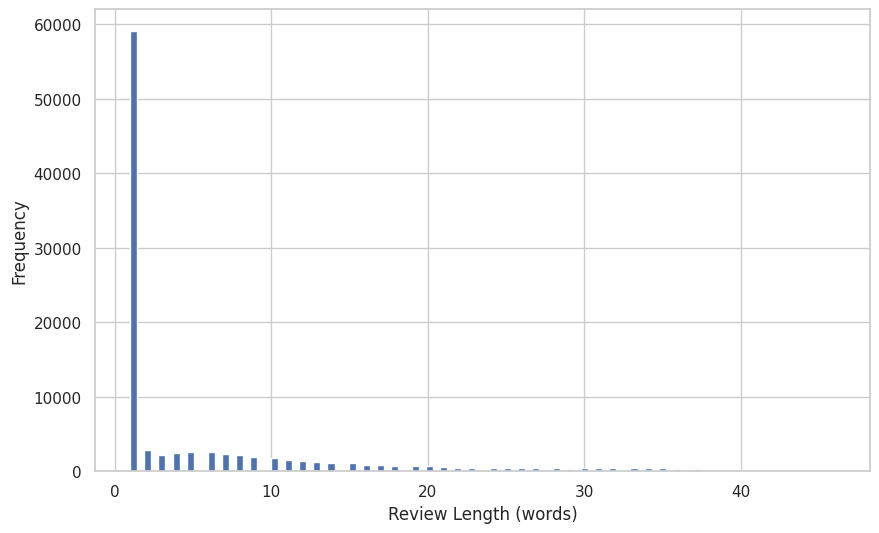

In [96]:
# Getting the number of words by splitting them by a space
words_per_review = df.review_comment_message.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,6))
words_per_review.hist(bins = 100)
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.show()

Observation(s):
* The word cloud for the review_messages are shown above.The messages are in Portuguese language and the most frequent words are antes prazo,produto entregue,produto chegou e.t.c.

* The most frequent word is ```'o'``` which means ```The``` , other frequent words are ``` e,produto,a``` which means ``` and, product,the``` respectively.

### 3.2.6. RFM -Analysis

**What is RFM?**

Behavioral segmentation by 3 important features:

Recency — number of days since the last purchase

Frequency — number of transactions made over a given period

Monetary — amount spent over a given period of time

More details - https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17

In [97]:
# https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
PRESENT = datetime(2018,9,3)
rfm= df.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (PRESENT - date.max()).days,
                                        'order_id': lambda num: len(num),
                                        'payment_value': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(float)

In [98]:
rfm.head()

recency  frequency  monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19
0000f46a3911fa3c0805444483337064      541          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62
0004aac84e0df4da2b147fca70cf8255      292          1    196.89

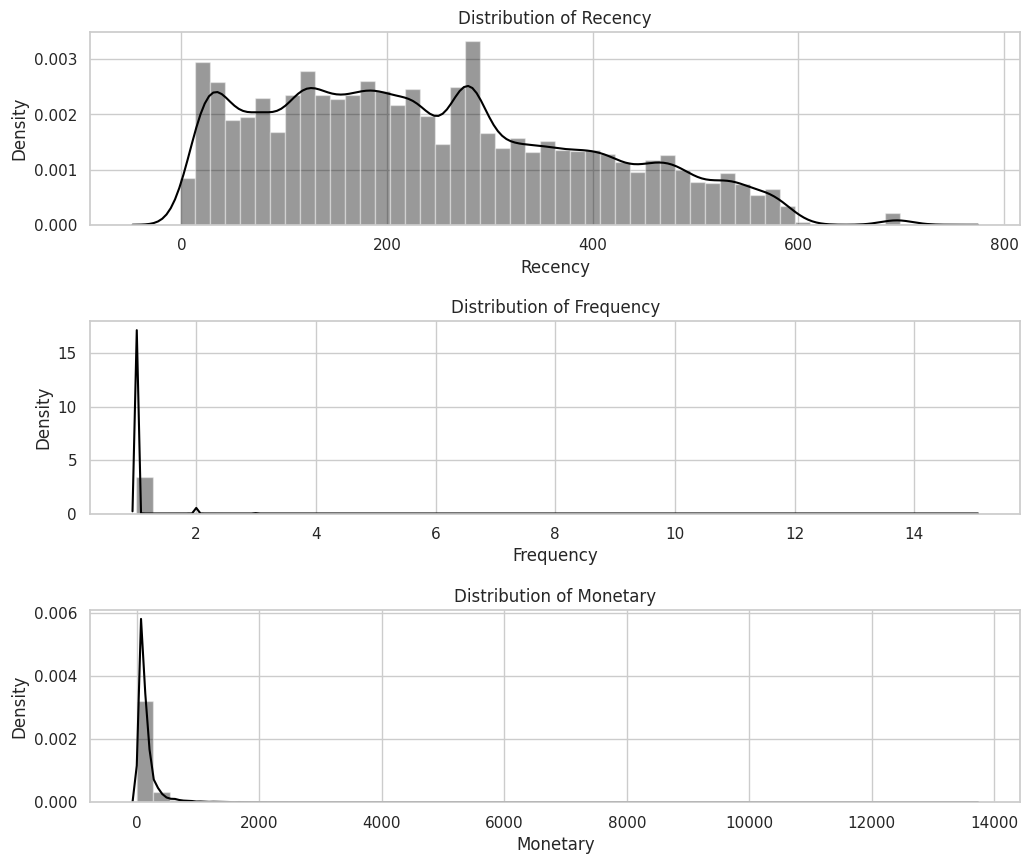

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))

# Plot distribution of R
plt.subplot(3, 1, 1)
sns.distplot(rfm['recency'], color='black')
plt.xlabel('Recency')
plt.ylabel('Density')
plt.title('Distribution of Recency')

# Add gap between subplots
plt.subplots_adjust(hspace=0.5)

# Plot distribution of F
plt.subplot(3, 1, 2)
sns.distplot(rfm['frequency'], color='black')
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title('Distribution of Frequency')

# Plot distribution of M
plt.subplot(3, 1, 3)
sns.distplot(rfm['monetary'], color='black')
plt.xlabel('Monetary')
plt.ylabel('Density')
plt.title('Distribution of Monetary')

# Show the plot
plt.show()


Observation(s)
* There are three density plots of recency, frequency and monetary are plotted.From the first plot  of recency we can observe that most of the users stayed with olist for long duration which is positive thing but order frequency is less.

* from the second plot of frequency most number of transaction or order is less than 5. from the third plot of monetary the maximum amount spend over the given very period is seems to less than 1500 approx.

In [100]:
# Create labels for Recency and Frequency
def partition(x):
    if x < 10:
      return 1
    if 10<=x<=35:
      return 2
    if 35<x<=50:
      return 3
    if 50<x<=75:
      return 4

rfm['f_quartile']=rfm['frequency'].map(lambda cw : partition(cw) )

# checking the review score now
rfm.f_quartile.value_counts()
r_labels = range(4, 0, -1);m_labels= range(1,5)

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, r_labels)
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, m_labels)

In [101]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

recency  frequency  monetary  f_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19           1   
0000f46a3911fa3c0805444483337064      541          1     86.22           1   
0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62           1   
0004aac84e0df4da2b147fca70cf8255      292          1    196.89           1   

                                 r_quartile m_quartile RFM_Score  
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2          4          3       413  
0000b849f77a49e4a4ce2b2a4ca5be3f          4          1       411  
0000f46a3911fa3c0805444483337064          1          2       112  
0000f6ccb0745a6a4b88665a16c9f078          2          1       211  
0004aac84e0df4da2b147fca70cf8255          2          4       214

In [102]:
rfm_count_unique = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
print(rfm_count_unique.sum())
rfm['RFM_Score_s'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
print(rfm['RFM_Score_s'].head())

17
customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    8
0000b849f77a49e4a4ce2b2a4ca5be3f    6
0000f46a3911fa3c0805444483337064    4
0000f6ccb0745a6a4b88665a16c9f078    4
0004aac84e0df4da2b147fca70cf8255    7
Name: RFM_Score_s, dtype: int64


In [103]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score_s'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score_s'] >= 8) and (df['RFM_Score_s'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score_s'] >= 7) and (df['RFM_Score_s'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score_s'] >= 6) and (df['RFM_Score_s'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score_s'] >= 5) and (df['RFM_Score_s'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score_s'] >= 4) and (df['RFM_Score_s'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

recency  frequency  monetary  f_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19           1   
0000f46a3911fa3c0805444483337064      541          1     86.22           1   
0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62           1   
0004aac84e0df4da2b147fca70cf8255      292          1    196.89           1   

                                 r_quartile m_quartile RFM_Score  RFM_Score_s  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2          4          3       413            8   
0000b849f77a49e4a4ce2b2a4ca5be3f          4          1       411            6   
0000f46a3911fa3c0805444483337064          1          2       112            4   
0000f6ccb0745a6a4b88665a16c9f078          2          1       211            4   
0004aac84e0df4da2b147fca70cf8255          2          4       214            7   

                                        RFM_Level  
customer_unique_id                                 
0000366f3b9a7992bf8c76cfdf3221e2        Champions  
0000b849f77a49e4a4ce2b2a4ca5be3f        Potential  
0000f46a3911fa3c0805444483337064  Needs Attention  
0000f6ccb0745a6a4b88665a16c9f078  Needs Attention  
0004aac84e0df4da2b147fca70cf8255            Loyal

In [104]:
# Calculate average values for each RFM_Level, and return a size of each segment
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()

                   recency frequency monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them      62.4       1.1    401.9   6036
Champions            114.9       1.1    257.3  12064
Loyal                171.2       1.0    202.6  17478
Needs Attention      368.1       1.0     62.2  11827
Potential            241.9       1.0    165.1  23083
Promising            300.6       1.0     86.4  17527
Require Activation   459.6       1.0     41.3   6072


In [105]:
!pip install squarify


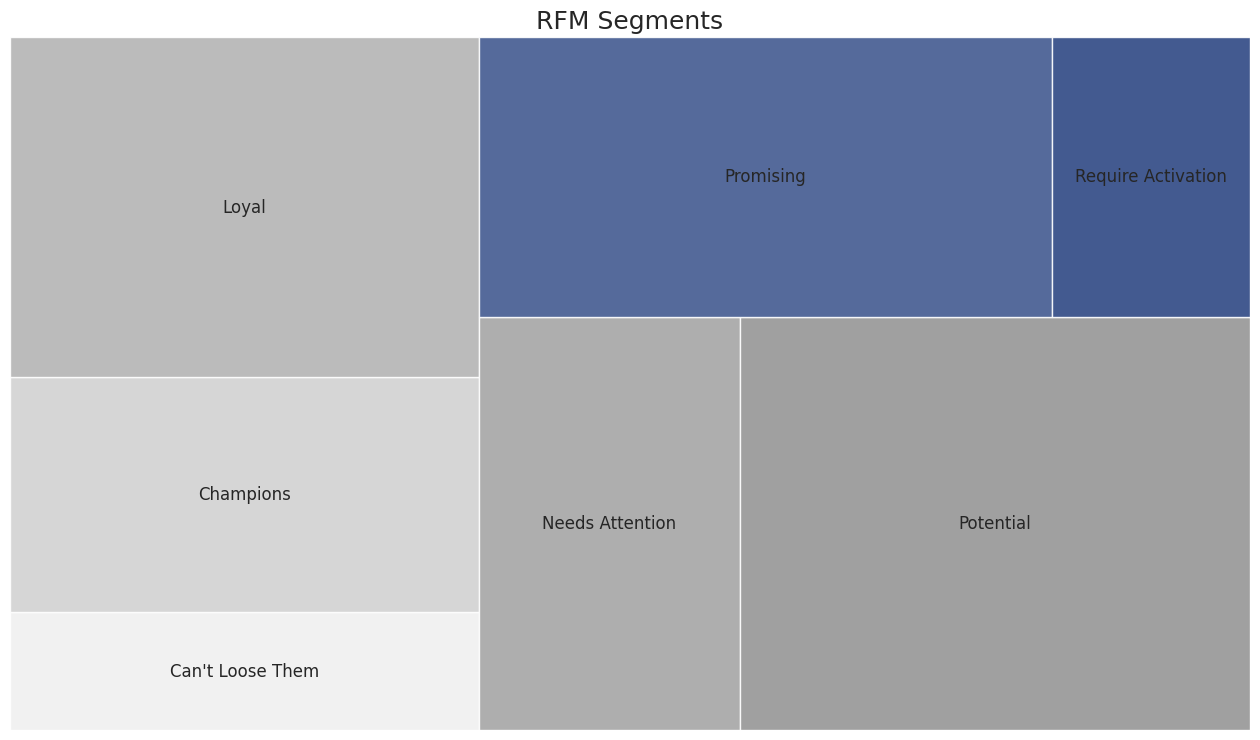

In [106]:
import squarify

rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'],
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential',
                     'Promising',
                     'Require Activation'], alpha=.9,color=['#f0f0f0','#d2d2d2','#b4b4b4','#a5a5a5','#969696','#425a90','#2e4884'])
plt.title("RFM Segments",fontsize=18)
plt.axis('off')
plt.show()

In [108]:
rfm.head()

recency  frequency  monetary  f_quartile  \
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      115          1    141.90           1   
0000b849f77a49e4a4ce2b2a4ca5be3f      118          1     27.19           1   
0000f46a3911fa3c0805444483337064      541          1     86.22           1   
0000f6ccb0745a6a4b88665a16c9f078      325          1     43.62           1   
0004aac84e0df4da2b147fca70cf8255      292          1    196.89           1   

                                 r_quartile m_quartile RFM_Score  RFM_Score_s  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2          4          3       413            8   
0000b849f77a49e4a4ce2b2a4ca5be3f          4          1       411            6   
0000f46a3911fa3c0805444483337064          1          2       112            4   
0000f6ccb0745a6a4b88665a16c9f078          2          1       211            4   
0004aac84e0df4da2b147fca70cf8255          2          4       214            7   

                                        RFM_Level  
customer_unique_id                                 
0000366f3b9a7992bf8c76cfdf3221e2        Champions  
0000b849f77a49e4a4ce2b2a4ca5be3f        Potential  
0000f46a3911fa3c0805444483337064  Needs Attention  
0000f6ccb0745a6a4b88665a16c9f078  Needs Attention  
0004aac84e0df4da2b147fca70cf8255            Loyal

Observation(s):
* Based on the RFM_Score_s all customers are categorised into 7 categories :

```
'Can\'t Loose Them' ====  RMF_Score_s  ≥  9
'Champions' ==== 8 ≤ RMF_Score_s < 9
'Loyal' ==== 7 ≤ RMF_Score_s <8
'Needs Attention' ==== 6 ≤ RMF_Score_s <7
'Potential' ==== 5 ≤ RMF_Score_s < 6
'Promising' ==== 4 ≤ RMF_Score_s < 5
'Require Activation' RMF_Score_s <4
```

* From the above square plot the highest percentage of customers lie within area of category potential.Few areas also there with colored in blue scale which show the percentage of comsumers which requries more attention so that they can retain in olist.

* We can use either RMF_Score_s or RMF_Level as feature to solve this problem.

In [109]:
#saving file

rfm.to_pickle('rfm.pkl')
df.to_pickle('final.pkl')

## Conclusions:
The target variable/class-label is imbalanced. We should be careful while choosing the performance metric of the models.

From the correlation matrix, we found strong positive correlations between the following pairs: (payment_value and price), (product_weight_g and freight_value, as well as product_width_cm), (product_length_cm and product_width_cm), and (product_height_cm and product_weight_g). However, most of the features do not seem to be helpful for the classification task.

In the univariate analysis of payment_type, we observed that 96% of users used credit card and boleto, suggesting that this could be an important feature.

Additionally, from the univariate analysis of consumer_state, we found that 42% of total consumers are from SP (São Paulo), 12.9% are from RJ (Rio de Janeiro), and 11.7% are from MG (Minas Gerais).

Analyzing the product_category feature, we observed that the most ordered products are from the bed_bath_table category, followed by health beauty and sports_leisure between 2016 and 2018. On the other hand, security_and_services products are the least ordered.

The different timestamps also seem to be important features, as many new features can be explored from them. We observed that within the period of 2016-2018, the total number of orders received increased until November 2017 and then showed a slight decrement. From the month, day, and time, we observed that the highest number of orders is received in February, on Mondays, and during the afternoon.

Numerical features like price, payment_value, freight_value, product_height_cm, and product_length_cm do not seem to be helpful for this classification problem, as observed from the univariate and bivariate analysis.

As the review_message can be an important feature for this problem, basic text analysis was performed. The most frequent words found in the reviews are 'o', 'e', 'produto', 'a', etc.

RMF Analysis was also conducted to understand whether new features can be created from it. It was found that one numerical or categorical feature can be extracted from it.